In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from a_api import TextMetrics

model_family = 'multiclass_view_cleaned'
if not os.path.exists('../../data/models/distortions/split_combined/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/split_combined/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = '../../data/models/distortions/split_combined/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'../../data/models/distortions/split_combined/{model_family}/{name_split_folder}/{m}.txt'
        #metrics[m] = './data/dict/' + 'en' + '/' + m + '.txt'
    return metrics

# Create Datasets
## Merge original binary and multiclass datasets into one

In [2]:
binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = pd.concat([df1, df2], ignore_index=True)
# df3 = pd.concat([df3.iloc[:100], df3.iloc[-100:]], ignore_index=True) # hack for test
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [3]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'../../data/models/distortions/split_combined/{model_family}/{name_split_folder}'
    distortion_file_path = f"{output_dir}/All_distortions.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram) 
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")

    old_distortion_file = f"{output_dir}/Distortion.txt"
    os.remove(old_distortion_file)
    os.rename(distortion_file_path, old_distortion_file)
    
    return (list(set(distortions_labels) - {'No_Distortion'}))
    #return (list(set(distortions_labels)))

### Evaluate functions

In [4]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [5]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=False)
    
    elif ngram_selection_metric in ['F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','FN*UFN*UF/D/D','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
        norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
        norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=False)
        
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'UFN/D/D':norm_uniq_n_gram_dicts,
            'FN*UFN':norm_norm_uniq,
            'FN*UFN/D':norm_norm_uniq_norm,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tAny distortion (threshold, accuracy, F1 score):')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_any,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    avg_res_acc = {}
    avg_res = {}
    if print_or_plot == 'print_results':
        print('\n\t\tAverage distortion (threshold, accuracy, F1 score):')
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_avg,threshold, tm)
        avg_res_acc[threshold] = acc
        avg_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc, avg_res_acc


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [6]:
def grid_search(df):
    part1 = df[df.index % 3 == 1]
    part2 = df[df.index % 3 == 2]
    part3 = df[df.index % 3 == 0]

    splits = [
        (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
    ]

    for ngram_selection_metric in ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any, first_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                    elif i == 2:
                        second_split_acc_any, second_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                    elif i == 3:
                        third_split_acc_any, third_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                                
                all_values_any = list(first_split_acc_any.values()) + list(second_split_acc_any.values()) + list(third_split_acc_any.values())
                min_value = min(all_values_any)
                max_value = max(all_values_any)
                mean_value = np.mean(all_values_any)

                print(f"\n\t(Any distortion) Min accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}")

                all_values_avg = list(first_split_acc_avg.values()) + list(second_split_acc_avg.values()) + list(third_split_acc_avg.values())
                min_value = min(all_values_avg)
                max_value = max(all_values_avg)
                mean_value = np.mean(all_values_avg)

                print(f"\t(Average distortion) Min accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}")


In [7]:
grid_search(df3)


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6448736998514116 0.7839710756251883
		 0.2 0.6448736998514116 0.7838408200180885
		 0.3 0.6438831104507182 0.7821872159951531
		 0.4 0.6389301634472511 0.769958977595456
		 0.5 0.5507677067855374 0.6560485400075843
		 0.6 0.475482912332838 0.45214692188308325
		 0.7 0.345715700842001 0.1234240212342402
		 0.8 0.3026250619118375 0.008450704225352112
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6448736998514116 0.7839710756251883
		 0.2 0.645864289252105 0.7843137254901961
		 0.3 0.6755819712729074 0.7940899088337001
		 0.4 0.7142149578999505 0.7713040031708285
		 0.5 0.441802872709262 0.3397773872290568
		 0.6 0.31996037642397224 0.0563573883161512
		 0.7 0.3011391778107974 0.004234297812279464
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any dist

		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6849925705794948 0.8125
		 0.7 0.6537890044576523 0.7857799570946981
		 0.8 0.5745418524021793 0.5991600559962669
		 0.9 0.3174839029222387 0.017118402282453635

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6889549281822684 0.8156194950088081
		 0.5 0.7171867261020307 0.8194751817894403
		 0.6 0.5517582961862308 0.5308449974079834
		 0.7 0.32639920752847945 0.04225352112676056
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.30361565131253093	Max accuracy: 0.6988608221892025	Mean accuracy: 0.6241080109331718
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.7434373452204062	Mean accuracy: 0.5536660979949738

N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 60
	FIRST C

		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6864784546805349 0.8139876579488686
		 0.8 0.683011391778108 0.8072289156626505
		 0.9 0.4923229321446261 0.43023902167871036

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8137687555163283
		 0.7 0.6428925210500248 0.776156473144986
		 0.8 0.5220406141654285 0.5187032418952618
		 0.9 0.3155027241208519 0.007183908045977011

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.6998514115898959 0.8234265734265734
		 0.9 0.6701337295690936 0.8002399520095982

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.6894502228826151 0.8160750953358757
		 0.9 0.5671124318969787 0.6719219219219219

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 sco

		 0.4 0.6186230807330362 0.7599750623441396
		 0.5 0.5269935611688955 0.6508226691042047
		 0.6 0.495789995047053 0.47579814624098865
		 0.7 0.35066864784546803 0.1075561606535058
		 0.8 0.3140168400198118 0.007168458781362008
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6315007429420505 0.7741347905282331
		 0.2 0.6324913323427439 0.7746051032806806
		 0.3 0.6592372461614661 0.7828282828282828
		 0.4 0.674591381872214 0.7464299498263219
		 0.5 0.4739970282317979 0.39590443686006827
		 0.6 0.3467062902426944 0.09719370294318959
		 0.7 0.3135215453194651 0.005738880918220947
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.654284299157999	Mean accuracy: 0.507768789096179
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.7142149578999505	Mean accuracy: 0.48748005063012506

N-gram selection metric: TF-IDF
N-gram max length: 

		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6859831599801882 0.8137485311398356
		 0.6 0.6854878652798415 0.8133999412283279
		 0.7 0.6815255076770679 0.8098195800059153
		 0.8 0.6795443288756811 0.7722632875747976
		 0.9 0.35859336305101536 0.12440838404327248

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6899455175829619 0.8152302243211335
		 0.6 0.696384348687469 0.7885477750948603
		 0.7 0.4110946012877662 0.25078764965343414
		 0.8 0.3150074294205052 0.005751258087706685
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.81548

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6998514115898959 0.8234265734265734
		 0.8 0.6939078751857355 0.818661971830986
		 0.9 0.6775631500742942 0.7405340773216421

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6939078751857355 0.819298245614035
		 0.6 0.6567607726597325 0.7928251121076233
		 0.7 0.586924219910847 0.7382297551789078
		 0.8 0.5220406141654285 0.5940260832982752
		 0.9 0.3140168400198118 0.040194040194040194

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.687964338781575 0.8151408450704225
		 0.9 0.674591381872214 0.8047548291233285

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6646854878652798 0.7985718536149955
		 0.7 0.5859336305101536 0.7389131792629605
		 0.8 0.4972758791480931 0.6541737649063033
		 0.9 0.413075780089153 0.2882882882882883

	(Any distortion) Min accuracy: 0.674591381872214	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6905508777722745
	(Average distortion

		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6810302129767212 0.8102533883323512
		 0.2 0.6810302129767212 0.8102533883323512
		 0.3 0.6810302129767212 0.8102533883323512
		 0.4 0.6805349182763745 0.8099027409372237
		 0.5 0.6740960871718673 0.8049792531120332
		 0.6 0.6592372461614661 0.7915151515151514
		 0.7 0.6394254581475978 0.7297698589458054
		 0.8 0.39128281327389797 0.20555914673561732
		 0.9 0.3145121347201585 0.004316546762589928

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6810302129767212 0.8102533883323512
		 0.2 0.6810302129767212 0.8102533883323512
		 0.3 0.6810302129767212 0.8102533883323512
		 0.4 0.7018325903912828 0.8172434729811779
		 0.5 0.7320455671124318 0.7805273833671399
		 0.6 0.4611193660227836 0.3546856465005931
		 0.7 0.34026745913818723 0.07628294036061026
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshol

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6988608221892025 0.8227405247813411
		 0.7 0.6968796433878157 0.8208430913348946
		 0.8 0.6874690440812283 0.7997461123452873
		 0.9 0.45022288261515603 0.35763888888888884

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6874690440812283 0.8128151883714031
		 0.7 0.5745418524021793 0.6367864693446089
		 0.8 0.3179791976225854 0.05099931082012406
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1

		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6820208023774146 0.8100591715976331
		 0.9 0.6329866270430906 0.6887862242755145

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6805349182763745 0.8099027409372237
		 0.6 0.6567607726597325 0.7928251121076233
		 0.7 0.5938583457157008 0.7439100562148656
		 0.8 0.5200594353640416 0.5652759084791387
		 0.9 0.3179791976225854 0.018531717747683533

	(Any distortion) Min accuracy: 0.6329866270430906	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6855428980243246
	(Average distortion) Min accuracy: 0.3051015354135711	Max accuracy: 0.7003467062902426	Mean accuracy: 0

		 0.8 0.3942545814759782 0.5445065176908752
		 0.9 0.4442793462109955 0.34843205574912894

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6869737493808816 0.8144450968878449

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6864784546805349 0.8140969162995594
		 0.5 0.683011391778108 0.8116539140670982
		 0.6 0.6419019316493314 0.7819004524886879
		 0.7 0.5324418028727093 0.6948933419521655
		 0.8 0.3813769192669638 0.5382624768946396
		 0.9 0.4507181773

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6988608221892025 0.8227405247813411
		 0.2 0.6988608221892025 0.8227405247813411
		 0.3 0.6988608221892025 0.8227405247813411
		 0.4 0.6983655274888558 0.8223972003499563
		 0.5 0.6944031698860822 0.8196433791289096
		 0.6 0.6835066864784547 0.8113374667847651
		 0.7 0.6840019811788014 0.7966857871255577
		 0.8 0.5393759286775631 0.5245398773006135
		 0.9 0.30460624071322434 0.014044943820224719

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6988608221892025 0.8227405247813411
		 0.2 0.6988608221892025 0.8227405247813411
		 0.3 0.6988608221892025 0.8227405247813411
		 0.4 0.6988608221892025 0.8223261250730568
		 0.5 0.7469044081228331 0.8361654376402692
		 0.6 0.5364041604754829 0.511482254697286
		 0.7 0.31996037642397224 0.0563573883161512
		 0.8 0.3011391778107974 0.004234297812279464
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, 

		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.687964338781575 0.8151408450704225
		 0.7 0.6844972758791481 0.8123711340206187
		 0.8 0.6661713719663199 0.782860824742268
		 0.9 0.40564635958395245 0.24623115577889446

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6889549281822684 0.8156194950088081
		 0.6 0.6790490341753344 0.8054054054054054
		 0.7 0.5760277365032194 0.6112624886466849
		 0.8 0.3184744923229321 0.019943019943019943
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.40564635958395245	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6592739346577879
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.7003467062902426	Mean accuracy: 0.593069543044778

		 0.9 0.3145121347201585 0.04155124653739613

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6844972758791481 0.8124816014130114
		 0.9 0.6631996037642397 0.7713517148621386

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6760772659732541 0.8067375886524822
		 0.6 0.629024269440317 0.7722712070538158
		 0.7 0.5661218424962853 0.7222574508560559
		 0.8 0.48489351163942546 0.6018376722817764
		 0.9 0.3308568598315998 0.05059732958538299

	THIRD COMBINATI

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5898959881129272 0.7361376673040152
		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5898959881129272 0.7361376673040152
		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5894006934125805 0.7333547764554519
		 0.2 0.619613670

		 0.3 0.6359583952451708 0.7434554973821991
		 0.4 0.6235760277365032 0.6957566052842274
		 0.5 0.5215453194650818 0.48888888888888893
		 0.6 0.3635463100544824 0.14046822742474918
		 0.7 0.31253095591877167 0.002873563218390805
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.649331352154532	Mean accuracy: 0.47643681323720954
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.649331352154532	Mean accuracy: 0.47643681323720954

N-gram selection metric: F
N-gram max length: 1
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.649331352154532 0.7873873873873873
		 0.3 0.6503219415552254 0.7870928829915561
		 0.4 0.6468548786527984 0.7793252862890745
		 0.5 0.6116889549281823 0.7163531114327062
		 0.6 0.4952947003467063 0.4766307139188496
		 0.7 0.32392273402674593 0.06698564593301436
		 0.8 

		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6572560673600792 0.7930622009569378
		 0.2 0.6587419514611194 0.7937743190661478
		 0.3 0.6597325408618128 0.7937556289402582
		 0.4 0.6592372461614661 0.788957055214724
		 0.5 0.6166419019316494 0.7342032967032966
		 0.6 0.5433382862803368 0.5541586073500967
		 0.7 0.3462109955423477 0.09589041095890412
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6572560673600792 0.7930622009569378
		 0.2 0.6587419514611194 0.7937743190661478
		 0.3 0.6646854878652798 0.7960228984633927
		 0.4 0.6617137196631996 0.7874260815437286
		 0.5 0.6116889549281823 0.707244212098581
		 0.6 0.4774640911342249 0.40896358543417366
		 0.7 0.32441802872709263 0.036723163841807904
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573

		 0.9 0.3016344725111441 0.005641748942172073

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6859831599801882 0.8137485311398356
		 0.6 0.6869737493808816 0.8142269253380364
		 0.7 0.6775631500742942 0.8057296329453894
		 0.8 0.6552748885586924 0.7281249999999999
		 0.9 0.32392273402674593 0.031227821149751592

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6854878652798415 0.8133999412283279
		 0.6 0.6785537394749876 0.8079313406333234
		 0.7 0.6329866270430906 0.7622714148219442
		 0.8 0.4269440316988608 0.30842797369994024
		 0.9 0.3135215453194651 0.001440922190201729

	THIRD COM

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5898959881129272 0.7361376673040152
		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5898959881129272 0.7361376673040152
		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5894006934125805 0.7333547764554519
		 0.2 0.619613670

		 0.3 0.6359583952451708 0.7434554973821991
		 0.4 0.6235760277365032 0.6957566052842274
		 0.5 0.5215453194650818 0.48888888888888893
		 0.6 0.3635463100544824 0.14046822742474918
		 0.7 0.31253095591877167 0.002873563218390805
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6503219415552254	Mean accuracy: 0.5008713517876471
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.7023278850916295	Mean accuracy: 0.4963953552363658

N-gram selection metric: F
N-gram max length: 2
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.649331352154532 0.7873873873873873
		 0.3 0.6503219415552254 0.7870928829915561
		 0.4 0.6468548786527984 0.7793252862890745
		 0.5 0.6116889549281823 0.7163531114327062
		 0.6 0.4952947003467063 0.4766307139188496
		 0.7 0.32392273402674593 0.06698564593301436
		 0.8 

		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764705
		 0.2 0.6840019811788014 0.8123529411764705
		 0.3 0.6835066864784547 0.8120035304501325
		 0.4 0.6795443288756811 0.8090882266155209
		 0.5 0.657751362060426 0.7921804511278197
		 0.6 0.6349678058444774 0.7544151949350215
		 0.7 0.4799405646359584 0.4205298013245033
		 0.8 0.3145121347201585 0.008595988538681949
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764705
		 0.2 0.6840019811788014 0.8123529411764705
		 0.3 0.6840019811788014 0.8122424955856387
		 0.4 0.6820208023774146 0.8089285714285714
		 0.5 0.6532937097573056 0.7774952320406866
		 0.6 0.5755324418028727 0.6281995661605206
		 0.7 0.3486874690440812 0.1023890784982935
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion

		 0.6 0.6983655274888558 0.8223972003499563
		 0.7 0.6547795938583457 0.7913798263992817
		 0.8 0.5413571074789499 0.7020592020592021
		 0.9 0.487369985141159 0.5913936044216344

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6869737493808816 0.8144450968878449

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6854878652798415 0.8133999412283279
		 0.7 0.65329370975

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5898959881129272 0.7361376673040152
		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5898959881129272 0.7361376673040152
		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5894006934125805 0.7333547764554519
		 0.2 0.619613670

		 0.3 0.671124318969787 0.7924999999999999
		 0.4 0.6869737493808816 0.7797909407665506
		 0.5 0.5725606736007924 0.5931164545025932
		 0.6 0.3803863298662704 0.1828870019595036
		 0.7 0.3140168400198118 0.007168458781362008
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6503219415552254	Mean accuracy: 0.5112358519986059
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6953937592867756	Mean accuracy: 0.5047236439014549

N-gram selection metric: F
N-gram max length: 3
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6844972758791481 0.8125919388055312
		 0.4 0.6795443288756811 0.8070384730092454
		 0.5 0.6547795938583457 0.7727420932507336
		 0.6 0.5963348192174344 0.6509635974304069
		 0.7 0.345715700842001 0.12574454003970878
		 0.8 0.29

		 0.5 0.6696384348687469 0.8009549388242315
		 0.6 0.6488360574541853 0.7712165214585349
		 0.7 0.48291233283803864 0.4482029598308669
		 0.8 0.3145121347201585 0.004316546762589928
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.678058444774641 0.8076923076923078
		 0.6 0.6617137196631996 0.7933434190620272
		 0.7 0.6285289747399703 0.7156937073540561
		 0.8 0.3551263001485884 0.11907983761840325
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6849925705794948 0.8129411764705882
		 0.5 0.6686478454680534 0.8003581020590868
		 0.6 0.6448736998514116 0.766068515497553
		 0.7

		 0.2 0.6166419019316494 0.7480468749999999
		 0.3 0.6334819217434373 0.7460535346602609
		 0.4 0.649331352154532 0.721259842519685
		 0.5 0.524517087667162 0.5066803699897224
		 0.6 0.3516592372461615 0.13824884792626727
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.5894006934125805 0.7333547764554519
		 0.2 0.6196136701337296 0.7467018469656991
		 0.3 0.6433878157503715 0.748075577326802
		 0.4 0.6433878157503715 0.7147385103011094
		 0.5 0.5047052996532937 0.4652406417112299
		 0.6 0.3615651312530956 0.13198653198653199
		 0.7 0.3145121347201585 0.004316546762589928
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.5894006934125805 0.7333547764554519
		 0.2 0.6196136701337296 0.7467018469656991
		 0.3 0.6433878157503715 0.748075577326802
		 0.4 0.6433878157503715 0.7147385103011

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.649331352154532 0.7873873873873873
		 0.3 0.6503219415552254 0.7870928829915561
		 0.4 0.6468548786527984 0.7793252862890745
		 0.5 0.6116889549281823 0.7163531114327062
		 0.6 0.4952947003467063 0.4766307139188496
		 0.7 0.32392273402674593 0.06698564593301436
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.6602278355621595 0.7923728813559322
		 0.3 0.7023278850916295 0.8110657026092424
		 0.4 0.7003467062902426 0.7852325168619099
		 0.5 0.5725606736007924 0.5946453734147488
		 0.6 0.3635463100544824 0.16720674011665587
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.640911342248638 0.7806354009077154
		 0.2 0.64289252

		 0.2 0.6587419514611194 0.7937743190661478
		 0.3 0.6646854878652798 0.7960228984633927
		 0.4 0.6617137196631996 0.7874260815437286
		 0.5 0.6116889549281823 0.707244212098581
		 0.6 0.4774640911342249 0.40896358543417366
		 0.7 0.32441802872709263 0.036723163841807904
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6859831599801882	Mean accuracy: 0.529653477152239
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6864784546805349	Mean accuracy: 0.5218388274356576

N-gram selection metric: F
N-gram max length: 4
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6968796433878157 0.8213660245183888
		 0.2 0.6968796433878157 0.8213660245183888
		 0.3 0.6968796433878157 0.8213660245183888
		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.6840019811788014 0.8112426035502958
		 0.6 0.6607231302625062 0.7798135647701703
		 0.7 0.50

		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6854878652798415 0.8133999412283279
		 0.6 0.6760772659732541 0.8060498220640571
		 0.7 0.6067360079247152 0.735861610113107
		 0.8 0.37196631996037643 0.16248348745046234
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6874690440812283 0.8147930730848253
		 0.7 0.6755819712729074 0.8046525499552639
		 0.8 0.6508172362555721 0.7260007773027595
		 0.9 0.3214462605250124 0.028368794326241138

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.815488

		 0.2 0.6508172362555721 0.7880973850315599
		 0.3 0.6691431401684002 0.7950920245398774
		 0.4 0.6944031698860822 0.7912013536379018
		 0.5 0.6012877662209014 0.6436476316954406
		 0.6 0.3808816245666171 0.2128463476070529
		 0.7 0.30361565131253093 0.011251758087201125
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.640911342248638 0.7806354009077154
		 0.2 0.6428925210500248 0.7815813389881854
		 0.3 0.6448736998514116 0.7821330902461258
		 0.4 0.6423972263496781 0.7739511584220413
		 0.5 0.5859336305101536 0.6948905109489051
		 0.6 0.4898464586428925 0.4491978609625668
		 0.7 0.3308568598315998 0.05059732958538299
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.640911342248638 0.7806354009077154
		 0.2 0.6433878157503715 0.7818181818181819
		 0.3 0.6631996037642397 0.7893432465923171
		 0.4 0.690440812283

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6968796433878157 0.8213660245183888
		 0.2 0.6968796433878157 0.8213660245183888
		 0.3 0.6968796433878157 0.8213660245183888
		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.6869737493808816 0.8140082401412595
		 0.6 0.6681525507677067 0.7916666666666666
		 0.7 0.5557206537890045 0.5953991880920162
		 0.8 0.3130262506191184 0.03747397640527411
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6968796433878157 0.8213660245183888
		 0.2 0.6968796433878157 0.8213660245183888
		 0.3 0.696384348687469 0.8210218978102188
		 0.4 0.6934125804853888 0.8188469417617794
		 0.5 0.6800396235760278 0.8068181818181819
		 0.6 0.6468548786527984 0.7497367497367496
		 0.7 0.3947498761763249 0.2512254901960784
		 0.8 0.3006438831104507 0.0028248587570621473
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.

		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6810302129767212 0.8099173553719008
		 0.7 0.6691431401684002 0.7924176507147297
		 0.8 0.5690936106983655 0.5743639921722113
		 0.9 0.3145121347201585 0.008595988538681949

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6849925705794948 0.8130511463844798
		 0.6 0.6661713719663199 0.7988059701492537
		 0.7 0.6230807330361565 0.7383980749398419
		 0.8 0.3789004457652303 0.1814621409921671
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.30856859831599803	Max accuracy: 0.6983655274888558	Mean accuracy: 0.6326013978317099
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6983655274888558	Mean accuracy: 0.6038743052116009

N-gram selection metric: UF
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST 

		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6869737493808816 0.8144450968878449

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6844972758791481 0.8127021464275214
		 0.9 0.6181277860326895 0.7621104597346497

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.68845963348

		 0.4 0.6503219415552254 0.7864488808227464
		 0.5 0.5894006934125805 0.7209693705822955
		 0.6 0.5344229816740961 0.5754290876242095
		 0.7 0.3526498266468549 0.14069690992767916
		 0.8 0.3011391778107974 0.004234297812279464
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6582466567607727 0.7939068100358423
		 0.2 0.6582466567607727 0.7939068100358423
		 0.3 0.6592372461614661 0.7937649880095924
		 0.4 0.6572560673600792 0.7870769230769231
		 0.5 0.6171371966319961 0.7179861364465524
		 0.6 0.4804358593363051 0.44643799472295514
		 0.7 0.3159980188211986 0.04561161022805805
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6463595839524517 0.7848101265822784
		 0.2 0.6463595839524517 0.7848101265822784
		 0.3 0.6468548786527984 0.7849170437405731
		 0.4 0.6349678058444774 0.7742725880551301
		 0.5 0.575037147102526 0.7091525423728813
		 0.6 0.518573551263

		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6820208023774146 0.8106194690265487
		 0.5 0.6597325408618128 0.7902290076335877
		 0.6 0.6280336800396236 0.7254113345521025
		 0.7 0.38831104507181774 0.212874442319949
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6968796433878157	Mean accuracy: 0.583493845504742
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5618476326747749

N-gram selection metric: UF
N-gram max length: 2
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6978702327885091 0.8220536756126021
		 0.2 0.6978702327885091 0.8220536756126021
		 0.3 0.6978702327885091 0.8220536756126021
		 0.4 0.6973749380881624 0.8217099503939305
		 0.5 0.6939078751857355 0.819298245614035
		 0.6 0.6795443288756811 0.8084098312111341
		 0.7 0.649331352154532 0.756030323914

		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6835066864784547 0.8115600117959305
		 0.7 0.6260525012382367 0.7628023876845743
		 0.8 0.4452699356116889 0.36723163841807904
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6874690440812283 0.8147930730848253
		 0.7 0.6820208023774146 0.8101714961561206
		 0.8 0.6612184249628529 0.7692307692307693
		 0.9 0.3838533927686974 0.19010416666666666

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884

		 0.7 0.3070827142149579 0.02099370188943317
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6210995542347697 0.766269477543538
		 0.2 0.6384348687469044 0.7741336633663366
		 0.3 0.6740960871718673 0.7866407263294423
		 0.4 0.671124318969787 0.7544378698224852
		 0.5 0.5517582961862308 0.559610705596107
		 0.6 0.35908865775136206 0.15645371577574968
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6181277860326895 0.7631336405529954
		 0.2 0.6210995542347697 0.7642526964560863
		 0.3 0.629024269440317 0.7660106216807249
		 0.4 0.6433878157503715 0.7579018157363819
		 0.5 0.5661218424962853 0.6214347450302506
		 0.6 0.4091134224863794 0.254840724547158
		 0.7 0.3174839029222387 0.012893982808022923
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average

		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6582466567607727	Mean accuracy: 0.5213802212316329
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6592372461614661	Mean accuracy: 0.514592849412067

N-gram selection metric: UF
N-gram max length: 3
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.696384348687469 0.8210218978102188
		 0.2 0.696384348687469 0.8210218978102188
		 0.3 0.696384348687469 0.8210218978102188
		 0.4 0.691431401684002 0.8175695461200584
		 0.5 0.678058444774641 0.8066627007733491
		 0.6 0.6523031203566122 0.7681638044914135
		 0.7 0.46904408122833086 0.4211663066954644
		 0.8 0.3031203566121842 0.009852216748768473
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.696384348687469 0.8210218978102188
		 0.2 0.696384348687469 0.8210218978102188
		 0.3 0.6958890539871223 0.8206775700934578
		 0.4 

		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6765725606736008 0.8066331063073734
		 0.6 0.6646854878652798 0.7951588502269289
		 0.7 0.645864289252105 0.7376146788990826
		 0.8 0.3784051510648836 0.17704918032786884
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8132902087621289
		 0.5 0.6706290242694403 0.8021422195775066
		 0.6 0.6448736998514116 0.7748822605965463
		 0.7 0.5433382862803368 0.5695611577964519
		 0.8 0.3155027241208519 0.011444921316165951
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.

		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6681525507677067 0.8008323424494649
		 0.8 0.54284299157999 0.6732743362831859
		 0.9 0.33382862803368 0.0930546190155091

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6795443288756811 0.8069233064756789
		 0.9 0.5710747894997523 0.5792031098153547

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6805349182763745 0.8099027409372237
		 0.7 0.65477959385834

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.649331352154532 0.7873873873873873
		 0.3 0.6503219415552254 0.7870928829915561
		 0.4 0.6468548786527984 0.7793252862890745
		 0.5 0.6116889549281823 0.7163531114327062
		 0.6 0.4952947003467063 0.4766307139188496
		 0.7 0.32392273402674593 0.06698564593301436
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.6508172362555721 0.7880973850315599
		 0.3 0.6691431401684002 0.7950920245398774
		 0.4 0.6944031698860822 0.7912013536379018
		 0.5 0.6012877662209014 0.6436476316954406
		 0.6 0.3808816245666171 0.2128463476070529
		 0.7 0.30361565131253093 0.011251758087201125
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.640911342248638 0.7806354009077154
		 0.2 0.64289252

		 0.1 0.6840019811788014 0.8123529411764705
		 0.2 0.6840019811788014 0.8123529411764705
		 0.3 0.6840019811788014 0.8122424955856387
		 0.4 0.6840019811788014 0.8090963494913227
		 0.5 0.6438831104507182 0.7663308417289567
		 0.6 0.5586924219910847 0.591096833409821
		 0.7 0.34323922734026746 0.08803301237964237
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.696384348687469	Mean accuracy: 0.5720837231486068
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.696384348687469	Mean accuracy: 0.5476675288463303

N-gram selection metric: UF
N-gram max length: 4
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6968796433878157 0.8213660245183888
		 0.2 0.6968796433878157 0.8213660245183888
		 0.3 0.6968796433878157 0.8213660245183888
		 0.4 0.6953937592867756 0.820333041191937
		 0.5 0.6869737493808816 0.8140082401412595
		 0.6 0.6681

		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8119103773584906
		 0.6 0.6681525507677067 0.7997609085475195
		 0.7 0.5809806835066865 0.689655172413793
		 0.8 0.3481921743437345 0.09863013698630137
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6864784546805349 0.8140969162995594
		 0.6 0.6810302129767212 0.8099173553719008
		 0.7 0.6691431401684002 0.7924176507147297
		 0.8 0.571570084200099 0.5790754257907542
		 0.9 0.3155027241208519 0.011444921316165951

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.81548841

		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.6998514115898959 0.8234265734265734
		 0.4 0.6909361069836553 0.8172231985940246
		 0.5 0.6716196136701337 0.8035555555555555
		 0.6 0.6181277860326895 0.7640036730945822
		 0.7 0.5383853392768697 0.699935608499678
		 0.8 0.4814264487369985 0.6224305805986297
		 0.9 0.5621594848935116 0.5452674897119342

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.68697374938

		 0.3 0.5968301139177811 0.5859613428280773
		 0.4 0.5364041604754829 0.4924078091106291
		 0.5 0.48588410104011887 0.4041331802525832
		 0.6 0.43833580980683506 0.3110571081409478
		 0.7 0.3630510153541357 0.13922356091030788
		 0.8 0.3155027241208519 0.011444921316165951
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6448736998514116	Mean accuracy: 0.47696879643387824
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6463595839524517	Mean accuracy: 0.47707886192284416

N-gram selection metric: FN
N-gram max length: 1
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.633977216443784 0.6690550828481863
		 0.2 0.6359583952451708 0.6595646132468735
		 0.3 0.5908865775136206 0.588235294117647
		 0.4 0.5235264982664686 0.4844587352625938
		 0.5 0.478949975235265 0.40765765765765766
		 0.6 0.43734522040614165 0.32860520094562645
		 0.7 0.36701337295690933 0.1754

		 0.2 0.7285785042100049 0.7677966101694915
		 0.3 0.6854878652798415 0.7050627032048306
		 0.4 0.5928677563150074 0.5788934426229508
		 0.5 0.5106488360574541 0.44680851063829785
		 0.6 0.4596334819217434 0.3517528223410576
		 0.7 0.4026745913818722 0.2308673469387755
		 0.8 0.3293709757305597 0.04647887323943662
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6315007429420505 0.712962962962963
		 0.2 0.6998514115898959 0.7485477178423237
		 0.3 0.6731054977711739 0.6975252062328139
		 0.4 0.5928677563150074 0.5810397553516821
		 0.5 0.5170876671619614 0.4598337950138504
		 0.6 0.4784546805349183 0.3902721482339317
		 0.7 0.4160475482912333 0.26358525921299186
		 0.8 0.33481921743437343 0.06541405706332638
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6349678058444774 0.7148936170212765
		 0.2 0.7107478949975236 0.7546218487394957
		 0.3 0.678058444774641 0.6976744186046512
		 0.

		 0.9 0.4710252600297177 0.39318181818181824

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.7176820208023774 0.8320565704183854
		 0.3 0.7781079742446756 0.8623232944068838
		 0.4 0.821198613174839 0.8817556501801507
		 0.5 0.799405646359584 0.8545780969479353
		 0.6 0.6894502228826151 0.7502986857825567
		 0.7 0.6334819217434373 0.6705253784505787
		 0.8 0.5700842000990589 0.5642570281124498
		 0.9 0.4289252105002476 0.3116417910447761

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6864784546805349 0.8140969162995594
		 0.2 0.6864784546805349 0.8140969162995594
		 0.3 0.6864784546805349 0.8140969162995594
		 0.4 0.6869737493808816 0.8143360752056403
		 0.5 0.6904408122833086 0.8160141301148072
		 0.6 0.7008420009905894 0.8206650831353919
		 0.7 0.7929668152550767 0.8650742414460942
		 0.8 0.8013868251609708 0.8403026682596575
		 0.9 0.495789995047053 0.42093287827076226

		Average distortio

		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6844972758791481 0.8127021464275214
		 0.9 0.5943536404160475 0.7430185127078757

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918166308953828
	(Average distortion) Min accuracy: 0.5943536404160475	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6820941793700586

N-gram selection metric: FN
N-gram max length: 2
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8207033184744923 0.8715400993612491
		 0.2 0.8291233283803864 0.8765652951699463
		 0.3 0.8509162951956414 0.8894601542416453
		 0.4 0.8662704309063893 0.897025171624714
		 0.5 0.8533927686973749

		 0.7 0.7795938583457157 0.8089308716187203
		 0.8 0.7067855373947499 0.7286892758936755
		 0.9 0.5527488855869243 0.5173703901656868

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8207033184744923 0.8709907341411262
		 0.2 0.854878652798415 0.892713291834493
		 0.3 0.8816245666171372 0.9092290163311813
		 0.4 0.8761763249133234 0.9014972419227738
		 0.5 0.8395245170876672 0.8677551020408163
		 0.6 0.8112927191679049 0.8407856247388215
		 0.7 0.7771173848439822 0.806368330464716
		 0.8 0.7023278850916295 0.7234238380119651
		 0.9 0.5477959385834572 0.5094035464803869

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7800891530460624 0.8431095406360425
		 0.2 0.8073303615651313 0.8598198198198198
		 0.3 0.8216939078751857 0.8656716417910448
		 0.4 0.8454680534918276 0.8778386844166014
		 0.5 0.8380386329866271 0.8671271840715157
		 0.6 0.8132738979692917 0.8431127756970453
		 0.7 0.779098563645369 0.8089117395029992
		 0.8 0.702823179791976

		 0.3 0.7270926201089648 0.8345842089462624
		 0.4 0.7820703318474492 0.8625858838226108
		 0.5 0.8519068845963348 0.900100233879051
		 0.6 0.9014363546310055 0.9270260359369269
		 0.7 0.8697374938088163 0.897864077669903
		 0.8 0.8152550767706785 0.8480651731160896
		 0.9 0.6854878652798415 0.7104423164614683

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6973749380881624 0.8199233716475095
		 0.2 0.7201584943041109 0.8311921123394084
		 0.3 0.8221892025755324 0.8853401469179175
		 0.4 0.9029222387320456 0.9315164220824598
		 0.5 0.8945022288261516 0.9201948295241663
		 0.6 0.8390292223873205 0.8704663212435233
		 0.7 0.7686973749380882 0.8022024565861923
		 0.8 0.6948984645864289 0.7215189873417721
		 0.9 0.5943536404160475 0.5923344947735192

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.687964338781575 0.8120525059665872
		 0.2 0.6978702327885091 0.8169267707082833
		 0.3 0.7221396731054978 0.8288068355202931
		 0.4 0.7865279841505

		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.687964338781575 0.8151408450704225
		 0.7 0.6944031698860822 0.817832890463537
		 0.8 0.7379891035165924 0.8383745798961196
		 0.9 0.8811292719167905 0.9154929577464789

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.7379891035165924 0.8400362866646508
		 0.4 0.8969787023278851 0.9289617486338797
		 0.5 0.8900445765230312 0.9155893536121673
		 0.6 0.7939574046557701 0.8247683235046335
		 0.7 0.6825160970777613 0.7011655011655011
		 0.8 0.5596830113917781 0.5313653136531366
		 0.9 0.4933135215453195 0.41841955656623087

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.8989598811292719	Mean accuracy: 0.7192229376479005
	(Average distortion) Min accuracy: 0.4888558692421991	Max accuracy: 0.9024269440316989	Mean accuracy: 0.714857006585585

N-gram selection metric: FN
N-gram max length: 2
N-gram inclusion threshold

		 0.1 0.8578504210004952 0.8983351044987602
		 0.2 0.861812778603269 0.900817632420903
		 0.3 0.8732045567112432 0.9081779053084649
		 0.4 0.8781575037147102 0.9098240469208211
		 0.5 0.8821198613174839 0.9087423312883435
		 0.6 0.8647845468053492 0.8911917098445595
		 0.7 0.8306092124814265 0.8594905505341002
		 0.8 0.8197127290737989 0.8489626556016597
		 0.9 0.8083209509658247 0.8378718056137411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8578504210004952 0.8983351044987602
		 0.2 0.8697374938088163 0.9059706828745083
		 0.3 0.895492818226845 0.9226823012092341
		 0.4 0.9049034175334324 0.9272175890826383
		 0.5 0.8707280832095097 0.8968787040695377
		 0.6 0.846458642892521 0.8741883116883118
		 0.7 0.8241703813769192 0.8532451426209177
		 0.8 0.8137691926696384 0.8432026688907422
		 0.9 0.8008915304606241 0.8305227655986509

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8192174343734522 0.8728665970045281
		 0.2 0.828628033680039

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.79247152055473 0.8642695173307419
		 0.2 0.8202080237741456 0.8802375453645661
		 0.3 0.8519068845963348 0.8988840040581672
		 0.4 0.8811292719167905 0.9160251924422673
		 0.5 0.8989598811292719 0.9254385964912281
		 0.6 0.8811292719167905 0.9086062452399085
		 0.7 0.8623080733036157 0.8910658307210031
		 0.8 0.8405151064883606 0.8715083798882681
		 0.9 0.8187221396731055 0.851340373679935

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.79247152055473 0.8642695173307419
		 0.2 0.8246656760772659 0.8828590337524819
		 0.3 0.8746904408122833 0.9129686962504299
		 0.4 0.9143140168400198 0.9370222060429559
		 0.5 0.9044081228330857 0.9274163219255359
		 0.6 0.8632986627043091 0.892103205629398
		 0.7 0.8424962852897474 0.8733067729083664
		 0.8 0.8291233283803864 0.8610551751913009
		 0.9 0.8147597820703318 0.8475957620211898

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
	

		 0.3 0.687964338781575 0.8126115407495539
		 0.4 0.7137196631996038 0.8250605326876513
		 0.5 0.7672114908370481 0.8513598987982289
		 0.6 0.8578504210004952 0.9026788741946422
		 0.7 0.9093610698365527 0.9322974472807991
		 0.8 0.878652798415057 0.903353057199211
		 0.9 0.8251609707776126 0.8545529460238978

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8111308466548253
		 0.2 0.6948984645864289 0.8164481525625745
		 0.3 0.7662209014363547 0.8525921299188008
		 0.4 0.8826151560178306 0.9187521426122729
		 0.5 0.9118375433382863 0.9337797619047619
		 0.6 0.8821198613174839 0.907103825136612
		 0.7 0.8360574541852402 0.8648427929767252
		 0.8 0.7800891530460624 0.8099315068493151
		 0.9 0.7256067360079247 0.7511230907457322

	(Any distortion) Min accuracy: 0.6840019811788014	Max accuracy: 0.9108469539375929	Mean accuracy: 0.7846935593344706
	(Average distortion) Min accuracy: 0.6840019811788014	Max accuracy: 0.9172857850421	Mean accuracy: 0.79859849

		 0.9 0.5022288261515602 0.44871091607240815

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6889549281822684 0.8151854031783402

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.687964338781575 0.8149236192714453
		 0.4 0.7062902426944032 0.8237741456166419
		 0.5 0.8593363051015354 0.9051436205744823
		 0.6 0.8816245666171372 0.9066041422430636
		 0.7 0.7310549777117384 0.7566113850291349
		 0.8 0.5963348192174344 0.5839714139867279
		 0.9 0.5027241208519069 0.4327683615819209

	THIRD COMBINATION

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8325903912828133 0.8847203274215553
		 0.2 0.8439821693907875 0.8917153661051908
		 0.3 0.8603268945022289 0.9018789144050104
		 0.4 0.8756810302129767 0.9105169340463459
		 0.5 0.8865775136206042 0.9154669619785899
		 0.6 0.8766716196136701 0.9047801147227533
		 0.7 0.8628033680039624 0.8914151313210505
		 0.8 0.8355621594848935 0.8669871794871794
		 0.9 0.8142644873699851 0.8471259682022014

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8325903912828133 0.8847203274215553
		 0.2 0.8489351163942546 0.8947913073473611
		 0.3 0.883605745418524 0.9166962070187876
		 0.4 0.9049034175334324 0.9292557111274872
		 0.5 0.8910351659237247 0.9166666666666666
		 0.6 0.8603268945022289 0.889584964761159
		 0.7 0.8429915799900941 0.8737554759060135
		 0.8 0.828132738979693 0.860137041515518
		 0.9 0.812778603268945 0.8457142857142858

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):


		 0.3 0.8360574541852402 0.8863714383796772
		 0.4 0.8593363051015354 0.899290780141844
		 0.5 0.8796433878157504 0.9106289076866495
		 0.6 0.878652798415057 0.9052224371373307
		 0.7 0.8553739474987617 0.882730923694779
		 0.8 0.8340762753838534 0.8629856850715746
		 0.9 0.8098068350668648 0.8397328881469115

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7845468053491828 0.8568608094768015
		 0.2 0.8177315502724121 0.8761776581426648
		 0.3 0.866765725606736 0.9055145767474534
		 0.4 0.8979692917285785 0.923760177646188
		 0.5 0.8979692917285785 0.9207692307692308
		 0.6 0.8682516097077762 0.894192521877486
		 0.7 0.8385339276869738 0.8671556642216789
		 0.8 0.8271421495789995 0.8564376799670917
		 0.9 0.8073303615651313 0.8373065662902551

	(Any distortion) Min accuracy: 0.7850421000495295	Max accuracy: 0.8969787023278851	Mean accuracy: 0.8477610845119513
	(Average distortion) Min accuracy: 0.7845468053491828	Max accuracy: 0.9187716691431401	Mean accuracy: 0.8510997

		 0.9 0.745418524021793 0.7778738115816768

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8132902087621288
		 0.2 0.6854878652798415 0.8132902087621288
		 0.3 0.6859831599801882 0.813529411764706
		 0.4 0.6869737493808816 0.8137890394814379
		 0.5 0.6919266963843487 0.8158673771462404
		 0.6 0.7196631996037642 0.8290030211480363
		 0.7 0.807825656265478 0.874189364461738
		 0.8 0.9009410599306588 0.9265246142542249
		 0.9 0.8608221892025756 0.8878243512974052

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8132902087621288
		 0.2 0.6864784546805349 0.8137687555163283
		 0.3 0.7315502724120851 0.8360556563823351
		 0.4 0.8637939574046558 0.9085467243099433
		 0.5 0.9227340267459139 0.9431486880466472
		 0.6 0.9009410599306588 0.923195084485407
		 0.7 0.8395245170876672 0.8685064935064933
		 0.8 0.7805844477464091 0.8099528099528099
		 0.9 0.7280832095096582 0.7532584269662921

	THIRD COMBINATION
		An

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.6998514115898959 0.8234265734265734
		 0.4 0.6909361069836553 0.8172231985940246
		 0.5 0.6716196136701337 0.8035555555555555
		 0.6 0.6181277860326895 0.7640036730945822
		 0.7 0.5383853392768697 0.699935608499678
		 0.8 0.4814264487369985 0.6224305805986297
		 0.9 0.5621594848935116 0.5452674897119342

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.4 0.5364041604754829 0.4924078091106291
		 0.5 0.48588410104011887 0.4041331802525832
		 0.6 0.43833580980683506 0.3110571081409478
		 0.7 0.3630510153541357 0.13922356091030788
		 0.8 0.3155027241208519 0.011444921316165951
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6285289747399703 0.6534195933456561
		 0.2 0.6354631005448241 0.6468330134357007
		 0.3 0.5968301139177811 0.5859613428280773
		 0.4 0.5364041604754829 0.4924078091106291
		 0.5 0.48588410104011887 0.4041331802525832
		 0.6 0.43833580980683506 0.3110571081409478
		 0.7 0.3630510153541357 0.13922356091030788
		 0.8 0.3155027241208519 0.011444921316165951
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6448736998514116	Mean accuracy: 0.47706051767468316
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6463595839524517	Mean accuracy: 0.47717058316364913

N-gram selection metric: UFN
N-gram max length: 

		 0.4 0.6022783556215948 0.5930055752660922
		 0.5 0.5190688459633482 0.461453133666112
		 0.6 0.4715205547300644 0.3749267721148213
		 0.7 0.41901931649331353 0.2673329169269206
		 0.8 0.3313521545319465 0.05196629213483146
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6448736998514116 0.7234863092942537
		 0.2 0.7152055473006439 0.7593135203013813
		 0.3 0.683011391778108 0.7042513863216265
		 0.4 0.5928677563150074 0.5788934426229508
		 0.5 0.512630014858841 0.4502793296089385
		 0.6 0.4640911342248638 0.3605200945626478
		 0.7 0.4145616641901932 0.25753768844221103
		 0.8 0.3303615651312531 0.04922644163150492
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.620604259534423 0.708079268292683
		 0.2 0.6929172857850421 0.745693191140279
		 0.3 0.671124318969787 0.698455949137148
		 0.4 0.591877166914314 0.58130081300813
		 0.5 0.5165923724616147 0.45898004434589806
		 0.6 0.481921

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6993561168895492 0.8230836490819002
		 0.8 0.7161961367013373 0.8295150252900922
		 0.9 0.804358593363051 0.8471953578336557

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.70827142149579 0.8276265730172666
		 0.3 0.7553244180287271 0.8510253317249699
		 0.4 0.8028727092620109 0.8729246487867177
		 0.5 0.8068350668647846 0.866346812885538
		 0.6 0.7429420505200595 0.8034835289663007
		 0.7 0.6275383853392769 0.6874480465502909
		 0.8 0.5894006934125805 0.6387799564270152
		 0.9 0.5755324418028727 0.5755324418028727

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):

		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8154884130243473
		 0.9 0.6869737493808816 0.8144450968878449

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6844972758791481 0.8127021464275214
		 0.9 0.5943536404160475 0.7430185127078757

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918166308953828
	(Average distortion) Min accuracy: 0.5943536404160475	Max ac

		 0.8 0.7067855373947499 0.7352415026833631
		 0.9 0.5334323922734027 0.5005302226935313

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8202080237741456 0.8708644610458911
		 0.2 0.8380386329866271 0.8819068255687973
		 0.3 0.8628033680039624 0.89721706864564
		 0.4 0.8727092620108965 0.9004261913986826
		 0.5 0.8514115898959881 0.8788368336025847
		 0.6 0.8142644873699851 0.8436848686952897
		 0.7 0.7795938583457157 0.8089308716187203
		 0.8 0.7067855373947499 0.7286892758936755
		 0.9 0.5522535908865776 0.5165775401069518

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8202080237741456 0.8708644610458911
		 0.2 0.8538880633977216 0.8922177566678845
		 0.3 0.8816245666171372 0.9093667045885476
		 0.4 0.8771669143140168 0.9023622047244093
		 0.5 0.8395245170876672 0.8677551020408163
		 0.6 0.8112927191679049 0.8407856247388215
		 0.7 0.7771173848439822 0.806368330464716
		 0.8 0.7023278850916295 0.7234238380119651
		 0.9 0.5473006438831

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6958890539871223 0.8206775700934578
		 0.2 0.696384348687469 0.8209173239848087
		 0.3 0.6998514115898959 0.822599531615925
		 0.4 0.7062902426944032 0.825228411435308
		 0.5 0.7563150074294205 0.8497251069028711
		 0.6 0.8573551263001485 0.9039359573048699
		 0.7 0.8945022288261516 0.9206703910614525
		 0.8 0.8439821693907875 0.8746518105849582
		 0.9 0.736998514115899 0.7688289072703527

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6958890539871223 0.8206775700934578
		 0.2 0.7048043585933631 0.8250146799765121
		 0.3 0.7691926696384349 0.8575794621026894
		 0.4 0.8519068845963348 0.9013526888815572
		 0.5 0.878652798415057 0.912718204488778
		 0.6 0.8553739474987617 0.8877786318216756
		 0.7 0.7894997523526498 0.8232848232848232
		 0.8 0.7097573055968301 0.7386262265834077
		 0.9 0.620604259534423 0.6285160038797284

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		

		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6934125804853888 0.8170263080106414
		 0.9 0.7969291728578505 0.8684210526315789

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.725111441307578 0.8334833483348334
		 0.4 0.8801386825160971 0.9184086311530681
		 0.5 0.8895492818226844 0.9159442140972484
		 0.6 0.795938583457157 0.8276150627615062
		 0.7 0.6919266963843487 0.7125693160813309
		 0.8 0.5661218424962853 0.5403987408184681
		 0.9 0.49975235264982665 0.4293785310734463

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7969291728578505	Mean accuracy: 0.7031166877625521
	(Average distortion) Min accuracy: 0.4913323427439326	Max acc

		 0.8 0.8246656760772659 0.8569118835893291
		 0.9 0.8098068350668648 0.8428805237315875

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8578504210004952 0.8983351044987602
		 0.2 0.861812778603269 0.900817632420903
		 0.3 0.8732045567112432 0.9081779053084649
		 0.4 0.8781575037147102 0.9098240469208211
		 0.5 0.8821198613174839 0.9087423312883435
		 0.6 0.8647845468053492 0.8911917098445595
		 0.7 0.8306092124814265 0.8594905505341002
		 0.8 0.8197127290737989 0.8489626556016597
		 0.9 0.8083209509658247 0.8378718056137411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8578504210004952 0.8983351044987602
		 0.2 0.8697374938088163 0.9059706828745083
		 0.3 0.895492818226845 0.9226823012092341
		 0.4 0.9049034175334324 0.9272175890826383
		 0.5 0.8707280832095097 0.8968787040695377
		 0.6 0.846458642892521 0.8741883116883118
		 0.7 0.8241703813769192 0.8532451426209177
		 0.8 0.8137691926696384 0.8432026688907422
		 0.9 0.80089153046062

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7954432887568103 0.8659526127880559
		 0.2 0.8221892025755324 0.8814007267922035
		 0.3 0.8514115898959881 0.8985801217038539
		 0.4 0.8811292719167905 0.9160251924422673
		 0.5 0.8994551758296186 0.9257769652650824
		 0.6 0.8826151560178306 0.9098516546215292
		 0.7 0.8628033680039624 0.891500195848022
		 0.8 0.8405151064883606 0.8715083798882681
		 0.9 0.8187221396731055 0.851340373679935

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7954432887568103 0.8659526127880559
		 0.2 0.826151560178306 0.8837363365352766
		 0.3 0.8741951461119366 0.9126547455295736
		 0.4 0.9143140168400198 0.9370222060429559
		 0.5 0.9049034175334324 0.9278195488721803
		 0.6 0.8637939574046558 0.8925361469323955
		 0.7 0.8429915799900941 0.8737554759060135
		 0.8 0.8291233283803864 0.8610551751913009
		 0.9 0.8147597820703318 0.8475957620211898

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score)

		 0.2 0.6869737493808816 0.8138987043580683
		 0.3 0.687964338781575 0.8143783146729523
		 0.4 0.6899455175829619 0.8151210868281158
		 0.5 0.7132243684992571 0.8253393665158371
		 0.6 0.7845468053491828 0.8608
		 0.7 0.8940069341258049 0.9241672572643516
		 0.8 0.895492818226845 0.9181853431562621
		 0.9 0.8355621594848935 0.8643790849673203

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8131803471609296
		 0.2 0.691431401684002 0.8160614112784175
		 0.3 0.7464091134224864 0.8436163714111179
		 0.4 0.846458642892521 0.8976897689768977
		 0.5 0.8994551758296186 0.9266353451391399
		 0.6 0.8781575037147102 0.9052388289676425
		 0.7 0.8370480435859337 0.8664230613073488
		 0.8 0.7850421000495295 0.8150042625745951
		 0.9 0.7295690936106983 0.7555953446732319

	(Any distortion) Min accuracy: 0.6840019811788014	Max accuracy: 0.9083704804358593	Mean accuracy: 0.7676334085447508
	(Average distortion) Min accuracy: 0.6840019811788014	Max accuracy: 0.903912

		 0.8 0.5998018821198613 0.6
		 0.9 0.5007429420505201 0.4461538461538461

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6874690440812283 0.8144663334313437

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.7013372956909361 0.8212273940112659
		 0.5 0.8528974739970282 0.9011647254575706
		 0.6 0.8806339772164438 0.9060428849902533
		 0.7 0.7310549777117384 0.7566113850291349
		 0.8 0.5958395245170877 0.5832482124616956
		 0.9 0.5017335314512135 0.430995

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8320950965824666 0.884418683941357
		 0.2 0.8439821693907875 0.8917153661051908
		 0.3 0.8603268945022289 0.9018789144050104
		 0.4 0.8756810302129767 0.9105169340463459
		 0.5 0.8865775136206042 0.9154669619785899
		 0.6 0.8766716196136701 0.9047801147227533
		 0.7 0.8628033680039624 0.8914151313210505
		 0.8 0.8360574541852402 0.867440929114938
		 0.9 0.8142644873699851 0.8471259682022014

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8320950965824666 0.884418683941357
		 0.2 0.8489351163942546 0.8947913073473611
		 0.3 0.883605745418524 0.9166962070187876
		 0.4 0.9049034175334324 0.9292557111274872
		 0.5 0.8910351659237247 0.9166666666666666
		 0.6 0.8603268945022289 0.889584964761159
		 0.7 0.8429915799900941 0.8737554759060135
		 0.8 0.8286280336800397 0.8605962933118452
		 0.9 0.812778603268945 0.8457142857142858

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
	

		 0.3 0.8350668647845468 0.8857632933104631
		 0.4 0.858345715700842 0.8986534372785259
		 0.5 0.8791480931154037 0.9103600293901544
		 0.6 0.8796433878157504 0.906068805566293
		 0.7 0.8538880633977216 0.8813831926015279
		 0.8 0.8340762753838534 0.8629856850715746
		 0.9 0.8103021297672115 0.8402169378389654

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7850421000495295 0.8571428571428572
		 0.2 0.8172362555720654 0.8758829465186682
		 0.3 0.8652798415056959 0.9046951646811493
		 0.4 0.8969787023278851 0.9230769230769231
		 0.5 0.8979692917285785 0.9208909370199694
		 0.6 0.8692421991084696 0.8950715421303657
		 0.7 0.8390292223873205 0.8676171079429734
		 0.8 0.8276374442793462 0.856907894736842
		 0.9 0.8083209509658247 0.8382783117425826

	(Any distortion) Min accuracy: 0.7850421000495295	Max accuracy: 0.8974739970282318	Mean accuracy: 0.848238034964137
	(Average distortion) Min accuracy: 0.7850421000495295	Max accuracy: 0.9187716691431401	Mean accuracy: 0.85165

		 0.9 0.7488855869242199 0.7815596725549332

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6864784546805349 0.8139876579488686
		 0.5 0.6864784546805349 0.8139876579488686
		 0.6 0.6899455175829619 0.8155568650559811
		 0.7 0.7275879148093115 0.8329283110571081
		 0.8 0.8593363051015354 0.9027397260273973
		 0.9 0.87518573551263 0.9016393442622951

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.7186726102030708 0.8297362110311751
		 0.4 0.841505695889054 0.8954931417374264
		 0.5 0.9177810797424467 0.9404591104734576
		 0.6 0.9044081228330857 0.9268107698141829
		 0.7 0.8454680534918276 0.8745980707395499
		 0.8 0.787518573551263 0.8176795580110497
		 0.9 0.733531451213472 0.7593917710196779

	THIRD COMBINATION
		An

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.6998514115898959 0.8234265734265734
		 0.4 0.6909361069836553 0.8172231985940246
		 0.5 0.6716196136701337 0.8035555555555555
		 0.6 0.6181277860326895 0.7640036730945822
		 0.7 0.5383853392768697 0.699935608499678
		 0.8 0.4814264487369985 0.6224305805986297
		 0.9 0.5621594848935116 0.5452674897119342

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6587419514611194 0.7941440095608008
		 0.2 0.662704309063893 0.7960467205750223
		 0.3 0.6810302129767212 0.8032987171655467
		 0.4 0.703318474492323 0.7971554351506942
		 0.5 0.58345715700842 0.6154549611339735
		 0.6 0.3848439821693908 0.1955958549222798
		 0.7 0.3150074294205052 0.01002147458840372
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6736007924715206	Mean accuracy: 0.5273971346284373
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.7142149578999505	Mean accuracy: 0.5142809971933301

N-gram selection metric: UFN/D/D
N-gram max length: 1
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.678058444774641 0.8081463990554899
		 0.2 0.678058444774641 0.8081463990554899
		 0.3 0.6770678553739475 0.80732

		 0.1 0.6844972758791481 0.8127021464275214
		 0.2 0.6844972758791481 0.8127021464275214
		 0.3 0.6854878652798415 0.8131803471609297
		 0.4 0.6849925705794948 0.8123893805309734
		 0.5 0.6651807825656265 0.7933985330073349
		 0.6 0.6240713224368499 0.7160493827160493
		 0.7 0.379395740465577 0.18689162881245946
		 0.8 0.3140168400198118 0.002879769618430526
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398355
		 0.2 0.6859831599801882 0.8137485311398355
		 0.3 0.6859831599801882 0.8137485311398355
		 0.4 0.683011391778108 0.8115429917550058
		 0.5 0.6671619613670133 0.799761620977354
		 0.6 0.6582466567607727 0.7824716267339217
		 0.7 0.5923724616146607 0.6216091954022988
		 0.8 0.3343239227340267 0.06406685236768803
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398355
		 0.2 0.6859831599801882 0.8137485311398355
		 0.3 

		 0.9 0.37592867756315007 0.1964285714285714

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.696384348687469 0.8210218978102188
		 0.7 0.6785537394749876 0.8058629973078074
		 0.8 0.5572065378900446 0.5958408679927667
		 0.9 0.30361565131253093 0.011251758087201125

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6835066864784547 0.8113374667847654
		 0.8 0.6835066864784547 0.786644407345576
		 0.9 0.3813769192669638 0.18205631958087753

		Average disto

		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6844972758791481 0.8127021464275214
		 0.9 0.5943536404160475 0.7430185127078757

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918166308953828
	(Average distortion) Min accuracy: 0.5943536404160475	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6820941793700586

N-gram selection metric: UFN/D/D
N-gram max length: 2
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6448736998514116 0.7841011743450769
		 0.2 0.649331352154532 0.7861027190332326
		 0.3 0.6488360574541853 0.7832467135432589
		 0.4 0.6701337295690936 0.781208935611038
		 0.5 0.627538385339

		 0.5 0.6225854383358098 0.7181952662721894
		 0.6 0.48439821693907875 0.4251794588625069
		 0.7 0.32491332342743934 0.03401842664776754
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6641901931649331 0.7982142857142857
		 0.2 0.6641901931649331 0.7982142857142857
		 0.3 0.6636948984645864 0.7977360738754841
		 0.4 0.657751362060426 0.7926792679267927
		 0.5 0.6111936602278356 0.7530670022019502
		 0.6 0.575037147102526 0.6624704956726987
		 0.7 0.433382862803368 0.3075060532687651
		 0.8 0.32441802872709263 0.036723163841807904
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6641901931649331 0.7982142857142857
		 0.2 0.6641901931649331 0.7982142857142857
		 0.3 0.6686478454680534 0.7999999999999999
		 0.4 0.6651807825656265 0.7928921568627452
		 0.5 0.6102030708271422 0.7151646760767282
		 0.6 0.495789995047053 0.4455337690631809
		 0

		 0.6 0.6641901931649331 0.7916410571604179
		 0.7 0.5433382862803368 0.5883928571428572
		 0.8 0.3055968301139178 0.016830294530154277
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6815255076770679 0.8101564806613523
		 0.6 0.6726102030708272 0.8033323415650104
		 0.7 0.6750866765725607 0.7797179314976495
		 0.8 0.4635958395245171 0.36331569664902996
		 0.9 0.3140168400198118 0.002879769618430526

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6854878652798415 0.8131803471609297
		 0.5 0.6770678553739475 0.8067575577949022
		 0.6 0.6567607726597325 0.7849829351535835
		 0.7 0.5388806339772164 0.574

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6993561168895492 0.8230836490819002
		 0.8 0.6899455175829619 0.8154481132075472
		 0.9 0.649331352154532 0.6948275862068964

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6998514115898959 0.8234265734265734
		 0.6 0.66765725606736 0.8007128007128007
		 0.7 0.6012877662209014 0.7505422993492408
		 0.8 0.5101535413571074 0.6420557365182772
		 0.9 0.337295690936107 0.10201342281879194

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score)

		 0.4 0.6483407627538386 0.7213500784929356
		 0.5 0.5676077265973254 0.5597579425113465
		 0.6 0.4264487369985141 0.28606658446362515
		 0.7 0.3496780584447746 0.10497614178595772
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6161466072313027 0.7542023469711385
		 0.2 0.6443784051510649 0.7668831168831168
		 0.3 0.6597325408618128 0.7641606591143152
		 0.4 0.6483407627538386 0.7213500784929356
		 0.5 0.5477959385834572 0.5301080802882141
		 0.6 0.37592867756315007 0.17105263157894735
		 0.7 0.31253095591877167 0.002873563218390805
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6701337295690936	Mean accuracy: 0.5146662264047109
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.703318474492323	Mean accuracy: 0.5029442518298389

N-gram selection metric: UFN/D/D
N-gram max length: 3
N-gram inclusion threshold: 80
	

		 0.8 0.37295690936106984 0.16047745358090185
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6835066864784547 0.8120035304501324
		 0.2 0.6835066864784547 0.8120035304501324
		 0.3 0.6844972758791481 0.8124816014130114
		 0.4 0.6849925705794948 0.8104886769964244
		 0.5 0.6641901931649331 0.7804404145077719
		 0.6 0.5572065378900446 0.5958408679927667
		 0.7 0.34175334323922735 0.08027681660899655
		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764705
		 0.2 0.6840019811788014 0.8123529411764705
		 0.3 0.6835066864784547 0.8120035304501325
		 0.4 0.6795443288756811 0.8090882266155209
		 0.5 0.6587419514611194 0.7929065223925458
		 0.6 0.6433878157503715 0.7614314115308151
		 0.7 0.5487865279841506 0.5330599692465402
		 0.8 0.3675086676572561 0.15036593479707253
		 0.9 0.31154036651807826 0

		Average distort

		 0.6 0.6929172857850421 0.8186073727325922
		 0.7 0.6869737493808816 0.8102102102102103
		 0.8 0.6433878157503715 0.6861377506538796
		 0.9 0.3382862803368004 0.10455764075067024

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6983655274888558 0.8223972003499563
		 0.2 0.6983655274888558 0.8223972003499563
		 0.3 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6934125804853888 0.8189529102076631
		 0.6 0.6686478454680534 0.8005961251862892
		 0.7 0.5720653789004457 0.6953455571227081
		 0.8 0.354135710747895 0.14993481095176012
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6835066864784547 0.8117820324005891
		 0.6 0.678058444774641 0.8074644549763033
		 0.7 0.676572560

		 0.8 0.6835066864784547 0.8099910793933989
		 0.9 0.6012877662209014 0.622597280825129

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6835066864784547 0.8120035304501325
		 0.6 0.6518078256562655 0.7892053973013493
		 0.7 0.5685983159980188 0.7246285172304774
		 0.8 0.4883605745418524 0.6203601617052554
		 0.9 0.3447251114413076 0.09321453050034272

	(Any distortion) Min accuracy: 0.6012877662209014	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6822592776035075
	(Average distortion) Min accuracy: 0.33580980683506684	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6106800212793279

N-gram selection metric: UFN/D/D
N-gram max length: 3
N-gram inclusion threshold: 0
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.

		 0.8 0.3135215453194651 0.001440922190201729
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6582466567607727 0.7934131736526947
		 0.2 0.6607231302625062 0.7946026986506747
		 0.3 0.6805349182763745 0.802329144958627
		 0.4 0.7077761267954433 0.8
		 0.5 0.595344229816741 0.6364040943480196
		 0.6 0.3972263496780584 0.22236421725239613
		 0.7 0.3159980188211986 0.008614501076812633
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7872596153846154
		 0.2 0.6508172362555721 0.7879699248120302
		 0.3 0.6532937097573056 0.788391777509069
		 0.4 0.6453689945517583 0.7770859277708592
		 0.5 0.6220901436354631 0.7275972866833273
		 0.6 0.5601783060921248 0.5568862275449101
		 0.7 0.3774145616641902 0.17465528562048588
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 scor

		 0.1 0.6968796433878157 0.8213660245183888
		 0.2 0.6968796433878157 0.8213660245183888
		 0.3 0.696384348687469 0.8210218978102188
		 0.4 0.6934125804853888 0.8188469417617794
		 0.5 0.6800396235760278 0.8068181818181819
		 0.6 0.6136701337295691 0.7196261682242989
		 0.7 0.3957404655770183 0.2533659730722154
		 0.8 0.3006438831104507 0.0028248587570621473
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764706
		 0.2 0.6840019811788014 0.8123529411764706
		 0.3 0.6840019811788014 0.8123529411764706
		 0.4 0.6840019811788014 0.8121319199057716
		 0.5 0.6736007924715206 0.8040440083258996
		 0.6 0.6582466567607727 0.7851805728518056
		 0.7 0.600297176820208 0.6462078035949145
		 0.8 0.4086181277860327 0.24430379746835443
		 0.9 0.3293709757305597 0.04647887323943662

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764706
		 0.2 0.6840019811788014 0.81235

		 0.5 0.6825160970777613 0.8113040918457461
		 0.6 0.6433878157503715 0.7815533980582524
		 0.7 0.5567112431896979 0.6556367833782224
		 0.8 0.3333333333333333 0.06136680613668061
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.316988608221892	Max accuracy: 0.6983655274888558	Mean accuracy: 0.6363619687047126
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6983655274888558	Mean accuracy: 0.5900060536018932

N-gram selection metric: UFN/D/D
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6983655274888558 0.8223972003499563
		 0.7 0.6958890539871223 0.8202576112412178
		 0.8 0.691431401684002 0.7985774329130295
		 0.9 0.38236750866765723 0.21225521

		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6825160970777613 0.8113040918457463
		 0.5 0.6656760772659732 0.7992863514719
		 0.6 0.6196136701337296 0.7651376146788991
		 0.7 0.537890044576523 0.6993232355784724
		 0.8 0.4779593858345716 0.6257102272727273
		 0.9 0.5641406636948985 0.5353748680042238

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8154884130243473
		 0.9 0.6874690440812283 0.8147930730848253

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.688459633481921

		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6334819217434373 0.6614821591948765
		 0.2 0.6295195641406637 0.6475023562676719
		 0.3 0.5814759782070332 0.5738779626828038
		 0.4 0.5195641406636949 0.4779332615715824
		 0.5 0.4764735017335314 0.4031620553359684
		 0.6 0.4239722634967806 0.3015015015015015
		 0.7 0.3516592372461615 0.13824884792626727
		 0.8 0.3026250619118375 0.008450704225352112
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6433878157503715 0.6610169491525424
		 0.2 0.6423972263496781 0.6498545101842871
		 0.3 0.5913818722139673 0.5767060030785018
		 0.4 0.5368994551758296 0.49157150625339857
		 0.5 0.4868746904408123 0.4039125431530494
		 0.6 0.4294205052005943 0.28976572133168926
		 0.7 0.35809806835066865 0.12313937753721244
		 0.8 0.3179791976225854 0.014316392269148175
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1

		 0.6 0.45071817731550273 0.33632555356074206
		 0.7 0.3798910351659237 0.18062827225130892
		 0.8 0.31896978702327883 0.02135231316725979
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6468548786527984	Mean accuracy: 0.4810962522701008
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6483407627538386	Mean accuracy: 0.4811879735109057

N-gram selection metric: FN*UFN
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6423972263496781 0.6844405594405594
		 0.2 0.649331352154532 0.6796380090497736
		 0.3 0.6077265973254086 0.6125244618395304
		 0.4 0.5334323922734027 0.5005302226935313
		 0.5 0.4814264487369985 0.4121280179674341
		 0.6 0.4432887568103021 0.34037558685446007
		 0.7 0.3774145616641902 0.19987269255251433
		 0.8 0.30856859831599803 0.02513966480446927
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F

		 0.6 0.4650817236255572 0.3624557260920897
		 0.7 0.4160475482912333 0.2608150470219436
		 0.8 0.33382862803368 0.05878236529041288
		 0.9 0.3135215453194651 0.001440922190201729

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6235760277365032 0.7132075471698114
		 0.2 0.6944031698860822 0.7496957403651116
		 0.3 0.6750866765725607 0.7042380522993689
		 0.4 0.5993065874195146 0.5916203937405351
		 0.5 0.5205547300643883 0.46696035242290745
		 0.6 0.48439821693907875 0.40138010350776304
		 0.7 0.4304110946012878 0.294478527607362
		 0.8 0.34076275383853394 0.08143547273982057
		 0.9 0.31203566121842496 0.0014378145219266715

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6270430906389302 0.7150964812712827
		 0.2 0.7092620108964834 0.7585355820649939
		 0.3 0.678058444774641 0.7018348623853212
		 0.4 0.5913818722139673 0.578005115089514
		 0.5 0.5156017830609212 0.4572697003329634
		 0.6 0.4794452699356117 0.3921341816078658
		 0.7 0.4249

		 0.1 0.8216939078751857 0.8721590909090908
		 0.2 0.8400198117880139 0.8834355828220859
		 0.3 0.8717186726102031 0.9031051253273475
		 0.4 0.8687469044081229 0.8973266175900814
		 0.5 0.8429915799900941 0.8739562624254473
		 0.6 0.8157503714710252 0.8485342019543974
		 0.7 0.7820703318474492 0.8157453936348409
		 0.8 0.6983655274888558 0.725552050473186
		 0.9 0.512630014858841 0.4663774403470716

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8360574541852402 0.8789762340036562
		 0.2 0.8390292223873205 0.8805586181550902
		 0.3 0.8598315998018822 0.8933283075763286
		 0.4 0.870232788509163 0.8973354231974922
		 0.5 0.8434868746904408 0.8715447154471545
		 0.6 0.8107974244675582 0.8403010033444817
		 0.7 0.7721644378405151 0.801210025929127
		 0.8 0.696384348687469 0.7163350300786672
		 0.9 0.5299653293709757 0.4799999999999999

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8360574541852402 0.8789762340036562
		 0.2 0.855373947498761

		 0.3 0.8454680534918276 0.8797224363916731
		 0.4 0.8514115898959881 0.8802873104549082
		 0.5 0.8320950965824666 0.86123618501842
		 0.6 0.8098068350668648 0.8397328881469115
		 0.7 0.774145616641902 0.8037865748709121
		 0.8 0.6993561168895492 0.7206626783248964
		 0.9 0.5299653293709757 0.4817039868924085

	(Any distortion) Min accuracy: 0.5284794452699356	Max accuracy: 0.8712233779098564	Mean accuracy: 0.7795755140975549
	(Average distortion) Min accuracy: 0.5274888558692422	Max accuracy: 0.8796433878157504	Mean accuracy: 0.7821070203437713

N-gram selection metric: FN*UFN
N-gram max length: 2
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8107974244675582 0.865776528460998
		 0.2 0.8231797919762258 0.8731793960923624
		 0.3 0.8494304110946013 0.888888888888889
		 0.4 0.8697374938088163 0.9000380083618397
		 0.5 0.8578504210004952 0.8876712328767123
		 0.6 0.8241703813769192 0.8564496562879094
		 0.7 0.7870232788509163

		 0.9 0.5780089153046062 0.5567117585848075

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8058444774640912 0.8650137741046832
		 0.2 0.8474492322932144 0.890625
		 0.3 0.8855869242199108 0.9140305173055452
		 0.4 0.8890539871223377 0.912975912975913
		 0.5 0.8519068845963348 0.8793868495361032
		 0.6 0.821198613174839 0.8503937007874016
		 0.7 0.7885091629519564 0.8180656156795909
		 0.8 0.7176820208023774 0.7413793103448275
		 0.9 0.5720653789004457 0.5476439790575915

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7662209014363547 0.8372413793103448
		 0.2 0.7999009410599307 0.8573446327683617
		 0.3 0.8216939078751857 0.8684210526315789
		 0.4 0.8489351163942546 0.8828275067230119
		 0.5 0.8444774640911342 0.8735909822866346
		 0.6 0.8207033184744923 0.8502894954507858
		 0.7 0.7914809311540366 0.821534548537516
		 0.8 0.7221396731054978 0.747183415953132
		 0.9 0.5527488855869243 0.5189131592967502

		Average distortion (threshold, 

		 0.5 0.7112431896978703 0.8282768777614139
		 0.6 0.7622585438335809 0.8528510116492949
		 0.7 0.8766716196136701 0.9149299624188588
		 0.8 0.8959881129271917 0.9206948640483382
		 0.9 0.8231797919762258 0.855640921957137

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6973749380881624 0.8217099503939305
		 0.2 0.7023278850916295 0.8241147205150717
		 0.3 0.7830609212481426 0.8649815043156598
		 0.4 0.8821198613174839 0.919322033898305
		 0.5 0.8959881129271917 0.9229074889867841
		 0.6 0.8266468548786527 0.8603351955307262
		 0.7 0.7305596830113917 0.7622377622377623
		 0.8 0.6319960376423972 0.6436450839328537
		 0.9 0.5651312530955919 0.5497435897435897

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8132902087621288
		 0.2 0.6854878652798415 0.8132902087621288
		 0.3 0.6864784546805349 0.8137687555163283
		 0.4 0.687964338781575 0.8141592920353982
		 0.5 0.6978702327885091 0.8185603807257585
		 0.6 0.7627538385339

		 0.7 0.8395245170876672 0.8680781758957655
		 0.8 0.821198613174839 0.850764778834229
		 0.9 0.8038632986627043 0.8338926174496645

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8241703813769192 0.8759175113596646
		 0.2 0.8375433382862804 0.8842625264643613
		 0.3 0.8657751362060426 0.9014186977082577
		 0.4 0.8895492818226844 0.9151122953939855
		 0.5 0.8761763249133234 0.9016522423288749
		 0.6 0.8494304110946013 0.877221324717286
		 0.7 0.8320950965824666 0.8611224907824663
		 0.8 0.8182268449727588 0.8479071694985495
		 0.9 0.8018821198613175 0.8319327731092437

	(Any distortion) Min accuracy: 0.8038632986627043	Max accuracy: 0.883605745418524	Mean accuracy: 0.8476326747748244
	(Average distortion) Min accuracy: 0.8008915304606241	Max accuracy: 0.9034175334323923	Mean accuracy: 0.8501274925247189

N-gram selection metric: FN*UFN
N-gram max length: 3
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.83902

		 0.3 0.87518573551263 0.9098712446351932
		 0.4 0.8796433878157504 0.9110867178924258
		 0.5 0.8821198613174839 0.9088122605363985
		 0.6 0.8652798415056959 0.8917197452229298
		 0.7 0.8325903912828133 0.8613617719442166
		 0.8 0.8207033184744923 0.8499170812603648
		 0.9 0.8088162456661714 0.838358458961474

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8509162951956414 0.8944230094703612
		 0.2 0.8687469044081229 0.9057945254177034
		 0.3 0.8974739970282318 0.9243697478991597
		 0.4 0.9058940069341258 0.9280847842543528
		 0.5 0.8712233779098564 0.8973954222573007
		 0.6 0.8479445269935612 0.8755573571139035
		 0.7 0.8246656760772659 0.8537190082644628
		 0.8 0.8142644873699851 0.8436848686952897
		 0.9 0.8013868251609708 0.8310155920775391

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8107974244675582 0.867911479944675
		 0.2 0.8246656760772659 0.8763966480446927
		 0.3 0.8375433382862804 0.8836053938963804
		 0.4 0.853888063397721

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7830609212481426 0.8594351732991015
		 0.2 0.8137691926696384 0.876882776686313
		 0.3 0.846458642892521 0.8959032907991942
		 0.4 0.8791480931154037 0.9150417827298051
		 0.5 0.9009410599306588 0.9271667880553534
		 0.6 0.8845963348192174 0.9115749525616699
		 0.7 0.8632986627043091 0.892018779342723
		 0.8 0.8410104011887073 0.8719585161547666
		 0.9 0.8192174343734522 0.8518067397482745

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7830609212481426 0.8594351732991015
		 0.2 0.8177315502724121 0.8791858174655286
		 0.3 0.8692421991084696 0.9098360655737705
		 0.4 0.9133234274393264 0.9365712214570496
		 0.5 0.9073798910351659 0.9298311444652908
		 0.6 0.8647845468053492 0.8934010152284263
		 0.7 0.8439821693907875 0.8746518105849582
		 0.8 0.8291233283803864 0.8610551751913009
		 0.9 0.8147597820703318 0.8475957620211898

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score)

		 0.2 0.6859831599801882 0.8136390358612581
		 0.3 0.6864784546805349 0.8138782710967363
		 0.4 0.6874690440812283 0.8142478657639094
		 0.5 0.6904408122833086 0.8153618906942393
		 0.6 0.6988608221892025 0.8180730101735487
		 0.7 0.7904903417533432 0.8646400000000001
		 0.8 0.9093610698365527 0.9334787350054525
		 0.9 0.8642892521050025 0.8907496012759171

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8136390358612581
		 0.2 0.6869737493808816 0.8141176470588236
		 0.3 0.7429420505200595 0.8420091324200913
		 0.4 0.8628033680039624 0.9075742409075742
		 0.5 0.9182763744427934 0.9394050679397723
		 0.6 0.8761763249133234 0.901883830455259
		 0.7 0.8073303615651313 0.8373065662902551
		 0.8 0.7270926201089648 0.7528039479587258
		 0.9 0.6513125309559188 0.6608863198458574

	(Any distortion) Min accuracy: 0.6854878652798415	Max accuracy: 0.9093610698365527	Mean accuracy: 0.7480417515088145
	(Average distortion) Min accuracy: 0.6443784051510649	Max acc

		 0.8 0.828132738979693 0.860137041515518
		 0.9 0.8112927191679049 0.8442991418062934

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.861812778603269 0.9017259598450158
		 0.2 0.8662704309063893 0.9045261669024045
		 0.3 0.8766716196136701 0.9112299465240641
		 0.4 0.8806339772164438 0.9123317570025464
		 0.5 0.8841010401188707 0.911430734292203
		 0.6 0.8722139673105498 0.8980237154150197
		 0.7 0.8400198117880139 0.8682170542635659
		 0.8 0.8236750866765725 0.8527708850289496
		 0.9 0.807825656265478 0.837384744341995

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.861812778603269 0.9017259598450158
		 0.2 0.8722139673105498 0.9083806818181819
		 0.3 0.8989598811292719 0.925764192139738
		 0.4 0.9073798910351659 0.9296728093268146
		 0.5 0.8806339772164438 0.9058225869480265
		 0.6 0.8538880633977216 0.8810004033884631
		 0.7 0.8301139177810798 0.8589058000822707
		 0.8 0.8177315502724121 0.8470490440565254
		 0.9 0.8013868251609708 0

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8291233283803864 0.8832487309644669
		 0.2 0.8424962852897474 0.8913934426229507
		 0.3 0.861812778603269 0.9033598891582959
		 0.4 0.8791480931154037 0.9132906894100923
		 0.5 0.8905398712233779 0.9186602870813396
		 0.6 0.8776622090143635 0.9056171188383646
		 0.7 0.8637939574046558 0.8922835879357619
		 0.8 0.8380386329866271 0.8692522990803678
		 0.9 0.8147597820703318 0.8475957620211898

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8291233283803864 0.8832487309644669
		 0.2 0.8469539375928677 0.8941418293936279
		 0.3 0.8850916295195641 0.918136908962597
		 0.4 0.908865775136206 0.9324026451138869
		 0.5 0.8945022288261516 0.9195315451454477
		 0.6 0.8613174839029223 0.890453834115806
		 0.7 0.8439821693907875 0.8746518105849582
		 0.8 0.8301139177810798 0.8619718309859155
		 0.9 0.8132738979692917 0.8461852305181559

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):

		 0.3 0.8266468548786527 0.8807089297886843
		 0.4 0.8593363051015354 0.8996466431095407
		 0.5 0.8816245666171372 0.9124862687660198
		 0.6 0.883605745418524 0.9095109742010011
		 0.7 0.8578504210004952 0.8849699398797595
		 0.8 0.8345715700842001 0.8634505314799673
		 0.9 0.8103021297672115 0.8402169378389654

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7686973749380882 0.8479322696190165
		 0.2 0.8073303615651313 0.8700300701637154
		 0.3 0.8578504210004952 0.8998953610045344
		 0.4 0.8979692917285785 0.9239852398523986
		 0.5 0.9004457652303121 0.9229589881180529
		 0.6 0.8697374938088163 0.8955105284068335
		 0.7 0.8405151064883606 0.8689991863303499
		 0.8 0.8271421495789995 0.8564376799670917
		 0.9 0.807825656265478 0.8377926421404682

	(Any distortion) Min accuracy: 0.7686973749380882	Max accuracy: 0.8989598811292719	Mean accuracy: 0.8456331517252765
	(Average distortion) Min accuracy: 0.7686973749380882	Max accuracy: 0.9177810797424467	Mean accuracy: 0.848

		 0.9 0.5621594848935116 0.5452674897119342

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6869737493808816 0.8144450968878449

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6825160970777613 0.8113040918457463
		 0.5 0.6656760772659732 0.7992863514719
		 0.6 0.6196136701337296 0.7651376146788991
		 0.7 0.537890044576523 0.6993232355784724
		 0.8 0.4779593858345716 0.6257102272727273
		 0.9 0.5641406636948985 0.5353748680042238

	THIRD COMBINATION
		A

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6067360079247152 0.6251180358829084
		 0.2 0.6067360079247152 0.6164251207729468
		 0.3 0.5636453689945518 0.5475089881869543
		 0.4 0.5101535413571074 0.46220772158781953
		 0.5 0.42149578999504705 0.29638554216867474
		 0.6 0.370975730559683 0.1848523748395379
		 0.7 0.3130262506191184 0.03747397640527411
		 0.8 0.300148588410104 0.001413427561837456
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6077265973254086 0.6257088846880907
		 0.2 0.6072313026250619 0.6167230546157564
		 0.3 0.5636453689945518 0.5475089881869543
		 0.4 0.5101535413571074 0.46220772158781953
		 0.5 0.42149578999504705 0.29638554216867474
		 0.6 0.370975730559683 0.1848523748395379
		 0.7 0.3130262506191184 0.03747397640527411
		 0.8 0.300148588410104 0.001413427561837456
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.613670133729

		 0.6 0.3784051510648836 0.17704918032786884
		 0.7 0.3328380386329866 0.06001395673412422
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6260525012382367 0.647690153989734
		 0.2 0.6295195641406637 0.6382978723404256
		 0.3 0.5913818722139673 0.578005115089514
		 0.4 0.5299653293709757 0.4817039868924085
		 0.5 0.4309063893016345 0.2955242182709994
		 0.6 0.3784051510648836 0.17704918032786884
		 0.7 0.3328380386329866 0.06001395673412422
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6404160475482912	Mean accuracy: 0.457028598682883
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.640911342248638	Mean accuracy: 0.45732210665345885

N-gram selection metric: FN*UFN/D
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F

		 0.5 0.45121347201584944 0.3349339735894357
		 0.6 0.3987122337790986 0.22179487179487178
		 0.7 0.34175334323922735 0.08027681660899655
		 0.8 0.3150074294205052 0.005751258087706685
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6428925210500248 0.6685057471264367
		 0.2 0.6518078256562655 0.6644391408114558
		 0.3 0.5998018821198613 0.5890132248219735
		 0.4 0.5408618127786032 0.49810503519220356
		 0.5 0.4492322932144626 0.33092659446450057
		 0.6 0.3972263496780584 0.21836865767501606
		 0.7 0.34125804853888064 0.07894736842105263
		 0.8 0.3150074294205052 0.005751258087706685
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6225854383358098 0.6561371841155235
		 0.2 0.6394254581475978 0.6566037735849056
		 0.3 0.6027736503219415 0.594949494949495
		 0.4 0.5373947498761763 0.4940411700975082
		 0.5 0.4561664190193165 0.34720570749108204
		 0.6 0.4011887072808321 0.2304264799490

		 0.3 0.8053491827637445 0.8486715440893339
		 0.4 0.8122833085685983 0.8485817019576508
		 0.5 0.8008915304606241 0.8351107465135358
		 0.6 0.7756315007429421 0.8092631578947368
		 0.7 0.7414561664190193 0.7736339982653946
		 0.8 0.6597325408618128 0.6791219056515647
		 0.9 0.4928182268449728 0.43237250554323725

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7776126795443289 0.8333951762523191
		 0.2 0.7939574046557701 0.8431372549019608
		 0.3 0.821198613174839 0.8590394377196406
		 0.4 0.8167409608717187 0.8506860371267151
		 0.5 0.7969291728578505 0.8307184145334435
		 0.6 0.7746409113422487 0.8082595870206489
		 0.7 0.7409608717186726 0.7731019522776573
		 0.8 0.6592372461614661 0.6785046728971962
		 0.9 0.4918276374442793 0.4306326304106548

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7820703318474492 0.8305084745762713
		 0.2 0.7919762258543833 0.836448598130841
		 0.3 0.8083209509658247 0.8458781362007167
		 0.4 0.81327389796

		 0.5 0.787518573551263 0.817988969028426
		 0.6 0.763744427934621 0.7928788536691272
		 0.7 0.7280832095096582 0.7539220080681308
		 0.8 0.6518078256562655 0.6615310544053924
		 0.9 0.4725111441307578 0.37900874635568516

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7488855869242199 0.8078817733990148
		 0.2 0.7691926696384349 0.8203546646106399
		 0.3 0.7919762258543833 0.8306451612903225
		 0.4 0.7999009410599307 0.8318068276436303
		 0.5 0.7845468053491828 0.8146570089475927
		 0.6 0.7632491332342743 0.792354474370113
		 0.7 0.7280832095096582 0.7539220080681308
		 0.8 0.6508172362555721 0.6602409638554216
		 0.9 0.4715205547300644 0.37711617046117923

	(Any distortion) Min accuracy: 0.4725111441307578	Max accuracy: 0.8132738979692917	Mean accuracy: 0.7312567644415092
	(Average distortion) Min accuracy: 0.4715205547300644	Max accuracy: 0.821198613174839	Mean accuracy: 0.7334030414763452

N-gram selection metric: FN*UFN/D
N-gram max length: 2
N-gram inclusion thre


	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8355621594848935 0.8783882783882784
		 0.2 0.8380386329866271 0.8796466691203534
		 0.3 0.8593363051015354 0.8929110105580695
		 0.4 0.8712233779098564 0.8981191222570534
		 0.5 0.8424962852897474 0.8706265256305938
		 0.6 0.8107974244675582 0.8403010033444817
		 0.7 0.770678553739475 0.7996538295110341
		 0.8 0.6874690440812283 0.705552963135791
		 0.9 0.5111441307578009 0.4476776720761052

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8355621594848935 0.8783882783882784
		 0.2 0.8543833580980683 0.890461997019374
		 0.3 0.8776622090143635 0.9049634474797998
		 0.4 0.8707280832095097 0.8963874553394203
		 0.5 0.8350668647845468 0.8635804997951658
		 0.6 0.8088162456661714 0.838358458961474
		 0.7 0.7677067855373948 0.7965292841648589
		 0.8 0.6849925705794948 0.7025257249766137
		 0.9 0.5071817731550272 0.4406970207982012

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score)

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6929172857850421 0.8088779284833539
		 0.2 0.7171867261020307 0.8212832550860719
		 0.3 0.7786032689450223 0.853969291081346
		 0.4 0.8405151064883606 0.8878048780487806
		 0.5 0.87518573551263 0.90625
		 0.6 0.8568598315998018 0.8868884540117417
		 0.7 0.8226844972758791 0.8550607287449393
		 0.8 0.765725606736008 0.7991507430997877
		 0.9 0.5839524517087668 0.5774647887323945

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6929172857850421 0.8088779284833539
		 0.2 0.7384843982169391 0.8324873096446701
		 0.3 0.8424962852897474 0.8911704312114991
		 0.4 0.8964834076275384 0.9225064886911383
		 0.5 0.8741951461119366 0.9013209013209014
		 0.6 0.8202080237741456 0.8527383367139959
		 0.7 0.7805844477464091 0.8142557651991614
		 0.8 0.7092620108964834 0.7380633645693887
		 0.9 0.5542347696879644 0.533195020746888

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.71

		 0.2 0.7746409113422487 0.83216525267429
		 0.3 0.7810797424467558 0.8347045624532535
		 0.4 0.8048538880633977 0.846930846930847
		 0.5 0.8142644873699851 0.847622917513206
		 0.6 0.8053491827637445 0.8357709987463434
		 0.7 0.7880138682516097 0.8180272108843538
		 0.8 0.7716691431401684 0.8012074169900819
		 0.9 0.7568103021297672 0.7854958497160333

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7696879643387816 0.8291069459757442
		 0.2 0.7810797424467558 0.8361749444032618
		 0.3 0.8018821198613175 0.8475609756097561
		 0.4 0.8241703813769192 0.8583964898284803
		 0.5 0.8142644873699851 0.8451053283767037
		 0.6 0.7989103516592373 0.8289806234203876
		 0.7 0.7835562159484893 0.813486982501067
		 0.8 0.7716691431401684 0.8012074169900819
		 0.9 0.7558197127290738 0.7844337560122432

	(Any distortion) Min accuracy: 0.7568103021297672	Max accuracy: 0.8325903912828133	Mean accuracy: 0.7962504356758939
	(Average distortion) Min accuracy: 0.7548291233283804	Max accurac

		 0.8 0.7815750371471025 0.81524926686217
		 0.9 0.7642397226349678 0.7976190476190476

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.804358593363051 0.852336448598131
		 0.2 0.8073303615651313 0.8541432320959881
		 0.3 0.8172362555720654 0.8602801968951154
		 0.4 0.826151560178306 0.8627297614391866
		 0.5 0.8221892025755324 0.8540056933712892
		 0.6 0.8033680039623576 0.8331231609920134
		 0.7 0.7810797424467558 0.8104631217838765
		 0.8 0.7721644378405151 0.801210025929127
		 0.9 0.7582961862308073 0.7865266841644795

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.804358593363051 0.852336448598131
		 0.2 0.8147597820703318 0.8589743589743589
		 0.3 0.8301139177810798 0.8683301343570058
		 0.4 0.8405151064883606 0.8718152866242038
		 0.5 0.8157503714710252 0.8460264900662252
		 0.6 0.7949479940564635 0.8245762711864407
		 0.7 0.7781079742446756 0.8073946689595873
		 0.8 0.770678553739475 0.7996538295110341
		 0.9 0.7548291233283804 0.

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.83308568598316 0.8837530182821663
		 0.2 0.8439821693907875 0.8905109489051095
		 0.3 0.8573551263001485 0.8988053408292339
		 0.4 0.8707280832095097 0.9058781103498016
		 0.5 0.8845963348192174 0.9127667540247099
		 0.6 0.866765725606736 0.8959381044487427
		 0.7 0.8494304110946013 0.8796516231195567
		 0.8 0.8306092124814265 0.8624296057924377
		 0.9 0.8112927191679049 0.8442991418062934

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.83308568598316 0.8837530182821663
		 0.2 0.8509162951956414 0.8948655256723717
		 0.3 0.8811292719167905 0.913978494623656
		 0.4 0.895492818226845 0.9214737625604764
		 0.5 0.8816245666171372 0.9083237437667818
		 0.6 0.8514115898959881 0.8814229249011858
		 0.7 0.8360574541852402 0.867440929114938
		 0.8 0.8241703813769192 0.8564496562879094
		 0.9 0.8103021297672115 0.8433537832310838

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 

		 0.2 0.6973749380881624 0.8134351145038167
		 0.3 0.7201584943041109 0.8239326893113119
		 0.4 0.7855373947498762 0.8579862249918007
		 0.5 0.8429915799900941 0.8895085395608227
		 0.6 0.87518573551263 0.9058295964125561
		 0.7 0.8652798415056959 0.892063492063492
		 0.8 0.8390292223873205 0.8676171079429734
		 0.9 0.8137691926696384 0.843594009983361

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6874690440812283 0.8084977238239758
		 0.2 0.7102526002971769 0.8199445983379501
		 0.3 0.7949479940564635 0.86435124508519
		 0.4 0.8850916295195641 0.916606757728253
		 0.5 0.8994551758296186 0.9220729366602687
		 0.6 0.8632986627043091 0.8898643256185156
		 0.7 0.836552748885587 0.8653061224489795
		 0.8 0.8048538880633977 0.8348700754400671
		 0.9 0.774145616641902 0.8037865748709121

	(Any distortion) Min accuracy: 0.6874690440812283	Max accuracy: 0.9053987122337791	Mean accuracy: 0.801056628694073
	(Average distortion) Min accuracy: 0.6874690440812283	Max accuracy: 0.

		 0.8 0.7850421000495295 0.8187134502923976
		 0.9 0.7662209014363547 0.799660441426146

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8107974244675582 0.8580980683506687
		 0.2 0.8137691926696384 0.8599105812220565
		 0.3 0.8221892025755324 0.865088312664412
		 0.4 0.8276374442793462 0.8656370656370657
		 0.5 0.828132738979693 0.8606985146527499
		 0.6 0.8137691926696384 0.8437240232751454
		 0.7 0.7890044576523031 0.8185689948892674
		 0.8 0.7756315007429421 0.8048255062473071
		 0.9 0.7597820703318474 0.7881170816950632

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8107974244675582 0.8580980683506687
		 0.2 0.8187221396731055 0.863126402393418
		 0.3 0.836552748885587 0.8742378048780488
		 0.4 0.8449727587914809 0.8766259361450531
		 0.5 0.8251609707776126 0.8557417245606865
		 0.6 0.804358593363051 0.8339638503572929
		 0.7 0.7850421000495295 0.8145299145299145
		 0.8 0.7736503219415553 0.8027621924902892
		 0.9 0.7563150074294205

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.8484398216939079 0.8941908713692946
		 0.2 0.8514115898959881 0.896049896049896
		 0.3 0.8608221892025756 0.9018512050296892
		 0.4 0.8722139673105498 0.9076592698639944
		 0.5 0.8845963348192174 0.9136077122728958
		 0.6 0.8766716196136701 0.9046342397548833
		 0.7 0.8623080733036157 0.8909803921568628
		 0.8 0.8345715700842001 0.8660785886126704
		 0.9 0.8098068350668648 0.8428805237315875

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8484398216939079 0.8941908713692946
		 0.2 0.8563645368994551 0.8991655076495133
		 0.3 0.8831104507181773 0.9160142348754449
		 0.4 0.9019316493313522 0.926829268292683
		 0.5 0.8875681030212976 0.9137865552601595
		 0.6 0.8593363051015354 0.8887147335423198
		 0.7 0.8424962852897474 0.8733067729083664
		 0.8 0.8271421495789995 0.8592174263816055
		 0.9 0.8083209509658247 0.8414584186808686

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score

		 0.2 0.8350668647845468 0.8841739130434783
		 0.3 0.8449727587914809 0.8895943562610229
		 0.4 0.8573551263001485 0.8957277335264301
		 0.5 0.8766716196136701 0.9062852841550622
		 0.6 0.8672610203070827 0.8946540880503144
		 0.7 0.8424962852897474 0.8708367181153533
		 0.8 0.8241703813769192 0.8536082474226805
		 0.9 0.8048538880633977 0.8348700754400671

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.8246656760772659 0.8777624309392266
		 0.2 0.8410104011887073 0.8878798463150542
		 0.3 0.8697374938088163 0.905293482175009
		 0.4 0.8925210500247648 0.9183289424162588
		 0.5 0.8860822189202575 0.9105058365758755
		 0.6 0.8568598315998018 0.8839823364110798
		 0.7 0.83308568598316 0.8620548505935326
		 0.8 0.8207033184744923 0.8502894954507858
		 0.9 0.8038632986627043 0.8338926174496645

	(Any distortion) Min accuracy: 0.8048538880633977	Max accuracy: 0.8855869242199108	Mean accuracy: 0.8509896721882854
	(Average distortion) Min accuracy: 0.8018821198613175	Max accur

		 0.8 0.4814264487369985 0.6224305805986297
		 0.9 0.5621594848935116 0.5452674897119342

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.6869737493808816 0.8144450968878449

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6825160970777613 0.8113040918457463
		 0.5 0.6656760772659732 0.7992863514719
		 0.6 0.6196136701337296 0.7651376146788991
		 0.7 0.537890044576523 0.6993232355784724
		 0.8 0.4779593858345716 0.6257102272727273
		 0.9 0.56414066369489

		 0.1 0.6582466567607727 0.7939068100358423
		 0.2 0.6582466567607727 0.7939068100358423
		 0.3 0.6572560673600792 0.7930622009569378
		 0.4 0.6503219415552254 0.7864488808227464
		 0.5 0.5894006934125805 0.7209693705822955
		 0.6 0.5344229816740961 0.5754290876242095
		 0.7 0.3526498266468549 0.14069690992767916
		 0.8 0.3011391778107974 0.004234297812279464
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6582466567607727 0.7939068100358423
		 0.2 0.6582466567607727 0.7939068100358423
		 0.3 0.6592372461614661 0.7937649880095924
		 0.4 0.6572560673600792 0.7870769230769231
		 0.5 0.6171371966319961 0.7179861364465524
		 0.6 0.4804358593363051 0.44643799472295514
		 0.7 0.3159980188211986 0.04561161022805805
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6463595839524517 0.7848101265822784
		 0.2 0.6463595839524517 0.7848101265822784
		 0.3 0.64685487865

		 0.1 0.6854878652798415 0.8133999412283279
		 0.2 0.6854878652798415 0.8133999412283279
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6820208023774146 0.8106194690265487
		 0.5 0.6597325408618128 0.7902290076335877
		 0.6 0.6280336800396236 0.7254113345521025
		 0.7 0.38831104507181774 0.212874442319949
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6968796433878157	Mean accuracy: 0.583493845504742
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6968796433878157	Mean accuracy: 0.5618476326747749

N-gram selection metric: CFR
N-gram max length: 1
N-gram inclusion threshold: 40
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6978702327885091 0.8220536756126021
		 0.2 0.6978702327885091 0.8220536756126021
		 0.3 0.6978702327885091 0.8220536756126021
		 0.4 0.6973749380881624 0.8217099503939305
		 0.5 0.6939078751857355 0.819298245

		 0.8 0.671124318969787 0.7762803234501349
		 0.9 0.35710747894997524 0.12178619756427604

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6849925705794948 0.8126104890984089
		 0.7 0.6691431401684002 0.7968369829683698
		 0.8 0.5398712233779098 0.5531505531505532
		 0.9 0.3145121347201585 0.004316546762589928

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6874690440812283 0.8147930730848253
		 0.7 0.6820208023774146 0.8101714961561206
		 0.8 0.662704309063893 0.7695431472081219
		 0.9 0.354631005

		 0.3 0.6250619118375433 0.7651256593236115
		 0.4 0.6463595839524517 0.7616822429906542
		 0.5 0.5809806835066865 0.6439393939393939
		 0.6 0.40663694898464586 0.27918170878459686
		 0.7 0.3070827142149579 0.02099370188943317
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6210995542347697 0.766269477543538
		 0.2 0.6384348687469044 0.7741336633663366
		 0.3 0.6740960871718673 0.7866407263294423
		 0.4 0.671124318969787 0.7544378698224852
		 0.5 0.5517582961862308 0.559610705596107
		 0.6 0.35908865775136206 0.15645371577574968
		 0.7 0.3031203566121842 0.009852216748768473
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6181277860326895 0.7631336405529954
		 0.2 0.6210995542347697 0.7642526964560863
		 0.3 0.629024269440317 0.7660106216807249
		 0.4 0.6433878157503715 0.7579018157363819
		 0.5 0.5661218424962853 0.62143474503

		 0.5 0.5933630510153541 0.6991572004397215
		 0.6 0.48538880633977216 0.4275482093663912
		 0.7 0.32491332342743934 0.03810868031051517
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6582466567607727	Mean accuracy: 0.5213802212316329
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6592372461614661	Mean accuracy: 0.514592849412067

N-gram selection metric: CFR
N-gram max length: 2
N-gram inclusion threshold: 60
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.696384348687469 0.8210218978102188
		 0.2 0.696384348687469 0.8210218978102188
		 0.3 0.696384348687469 0.8210218978102188
		 0.4 0.691431401684002 0.8175695461200584
		 0.5 0.678058444774641 0.8066627007733491
		 0.6 0.6523031203566122 0.7681638044914135
		 0.7 0.46904408122833086 0.4211663066954644
		 0.8 0.3031203566121842 0.009852216748768473
		 0.9 0.2996532937097573 0

		Average distortion (thre

		 0.5 0.6755819712729074 0.8056956392761792
		 0.6 0.6547795938583457 0.7827983795574945
		 0.7 0.5264982664685488 0.5582255083179297
		 0.8 0.3155027241208519 0.007183908045977011
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6765725606736008 0.8066331063073734
		 0.6 0.6646854878652798 0.7951588502269289
		 0.7 0.645864289252105 0.7376146788990826
		 0.8 0.3784051510648836 0.17704918032786884
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6854878652798415 0.8132902087621289
		 0.5 0.6706290242694403 0.8021422195775066
		 0.6 0.6448736998514116 0.7748822605965463
		 0.7

		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.6681525507677067 0.8008323424494649
		 0.8 0.5458147597820703 0.677453394301794
		 0.9 0.34274393263992076 0.11592271818787475

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6795443288756811 0.8069233064756789
		 0.9 0.578504210004953 0.5906685906685907

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493

		 0.7 0.31253095591877167 0.002873563218390805
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6463595839524517	Mean accuracy: 0.48652614972575353
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6785537394749876	Mean accuracy: 0.48779190284886176

N-gram selection metric: CFR
N-gram max length: 3
N-gram inclusion threshold: 80
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.649331352154532 0.7873873873873873
		 0.3 0.6503219415552254 0.7870928829915561
		 0.4 0.6468548786527984 0.7793252862890745
		 0.5 0.6116889549281823 0.7163531114327062
		 0.6 0.4952947003467063 0.4766307139188496
		 0.7 0.32392273402674593 0.06698564593301436
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.649331352154532 0.7873873873873873
		 0.2 0.6508172362555721 0.78

		 0.1 0.6840019811788014 0.8123529411764705
		 0.2 0.6840019811788014 0.8123529411764705
		 0.3 0.6835066864784547 0.8120035304501325
		 0.4 0.6795443288756811 0.8090882266155209
		 0.5 0.657751362060426 0.7921804511278197
		 0.6 0.6349678058444774 0.7544151949350215
		 0.7 0.4799405646359584 0.4205298013245033
		 0.8 0.3145121347201585 0.008595988538681949
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764705
		 0.2 0.6840019811788014 0.8123529411764705
		 0.3 0.6840019811788014 0.8122424955856387
		 0.4 0.6840019811788014 0.8090963494913227
		 0.5 0.6438831104507182 0.7663308417289567
		 0.6 0.5586924219910847 0.591096833409821
		 0.7 0.34323922734026746 0.08803301237964237
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.696384348687469	Mean accuracy: 0.5720837231486068
	(Average distortion) Min accuracy: 0.2996532937097573	Max accu


	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8121319199057716
		 0.6 0.6785537394749876 0.8079313406333234
		 0.7 0.6726102030708272 0.7932436659368156
		 0.8 0.5398712233779098 0.5223650385604113
		 0.9 0.3159980188211986 0.008614501076812633

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6840019811788014 0.8119103773584906
		 0.6 0.6681525507677067 0.7997609085475195
		 0.7 0.5809806835066865 0.689655172413793
		 0.8 0.3481921743437345 0.09863013698630137
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6909361069836553 0.8172231985940246
		 0.6 0.6384348687469044 0.7793228536880289
		 0.7 0.54284299157999 0.7036918138041734
		 0.8 0.3942545814759782 0.5445065176908752
		 0.9 0.4442793462109955 0.34843205574912894

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6354631005448241 0.776969696969697
		 0.2 0.6394254581475978 0.7788578371810451
		 0.3 0.657751362060426 0.7858692283854973
		 0.4 0.6800396235760278 0.7777013076393668
		 0.5 0.5720653789004457 0.6007393715341959
		 0.6 0.3843486874690441 0.1944264419961115
		 0.7 0.3150074294205052 0.01002147458840372
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6503219415552254	Mean accuracy: 0.5112358519986059
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.6944031698860822	Mean accuracy: 0.5031827270559317

N-gram selection metric: CFR
N-gram max length: 4
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6582466567607727 0.7939068100358423
		 0.2 0.6582466567607727 0.7939068100358423
		 0.3 0.6572560673600792 0.79306

		 0.1 0.6840019811788014 0.8123529411764706
		 0.2 0.6840019811788014 0.8123529411764706
		 0.3 0.6849925705794948 0.8128310771041789
		 0.4 0.6844972758791481 0.8120389495426379
		 0.5 0.6631996037642397 0.7919216646266829
		 0.6 0.620604259534423 0.7126781695423855
		 0.7 0.3779098563645369 0.18335500650195055
		 0.8 0.3140168400198118 0.002879769618430526
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8133999412283279
		 0.2 0.6854878652798415 0.8133999412283279
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6825160970777613 0.8111929307805597
		 0.5 0.6651807825656265 0.7983293556085918
		 0.6 0.6498266468548787 0.7759112519809825
		 0.7 0.5403665180782565 0.5516908212560386
		 0.8 0.3219415552253591 0.029766123316796598
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8133999412283279
		 0.2 0.6854878652798415 0.8133999412283279
		 0

		 0.9 0.35859336305101536 0.1563517915309446

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.696384348687469 0.8210218978102188
		 0.7 0.6602278355621595 0.791995148574894
		 0.8 0.4779593858345716 0.4544513457556935
		 0.9 0.3006438831104507 0.0028248587570621473

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6820208023774146 0.8102836879432623
		 0.8 0.6681525507677067 0.7754691689008042
		 0.9 0.3818722139673105 0.18324607329842932

		Average disto

		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.687964338781575 0.8151408450704225
		 0.4 0.6815255076770679 0.8106038291605302
		 0.5 0.6651807825656265 0.7989292088042831
		 0.6 0.6077265973254086 0.756007393715342
		 0.7 0.5334323922734027 0.695736434108527
		 0.8 0.4868746904408123 0.6292054402290623
		 0.9 0.5849430411094602 0.5689300411522633

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918349751435438
	(Average distortion) Min accuracy: 0.4779593858345716	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6257406490195

N-gram selection metric: FCR
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6097077761267955 0.6307403936269915
		 0.2 0.6111936602278356 0.6224146224146224
		 0.3 0.5676077265973254 0.5534526854219949
		 0.4 0.5146111936602278 0.46969696969696967
		 0.5 0.4764735017335314 0.

		 0.1 0.615651312530956 0.6290630975143402
		 0.2 0.6225854383358098 0.6238894373149061
		 0.3 0.58345715700842 0.5649249870667357
		 0.4 0.532937097573056 0.4849808847624249
		 0.5 0.48489351163942546 0.4002306805074971
		 0.6 0.43833580980683506 0.30853658536585366
		 0.7 0.3680039623576028 0.1481975967957276
		 0.8 0.31996037642397224 0.019985724482512488
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6017830609212481 0.626046511627907
		 0.2 0.6146607231302625 0.6234269119070668
		 0.3 0.5879148093115404 0.5733333333333334
		 0.4 0.5339276869737494 0.48830886351277863
		 0.5 0.48588410104011887 0.4041331802525832
		 0.6 0.4487369985141159 0.33233353329334137
		 0.7 0.3779098563645369 0.1758530183727034
		 0.8 0.3184744923229321 0.019943019943019943
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6037642397226349 0.6272134203168687
		 0.2 0.6186230807330362 0.6258503401360545
		

		 0.1 0.586924219910847 0.7270942408376964
		 0.2 0.6631996037642397 0.7624039133473095
		 0.3 0.7186726102030708 0.7762017336485422
		 0.4 0.6557701832590391 0.6801656695812242
		 0.5 0.5413571074789499 0.513655462184874
		 0.6 0.4759782070331847 0.4022598870056497
		 0.7 0.4492322932144626 0.351981351981352
		 0.8 0.40416047548291234 0.2596923076923077
		 0.9 0.3026250619118375 0.008450704225352112

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6017830609212481 0.7357001972386588
		 0.2 0.6612184249628529 0.7633217993079586
		 0.3 0.7157008420009906 0.7747252747252749
		 0.4 0.6884596334819217 0.7155133423790141
		 0.5 0.5661218424962853 0.5399159663865546
		 0.6 0.495789995047053 0.42093287827076226
		 0.7 0.46656760772659733 0.365350618738951
		 0.8 0.4120851906884596 0.2520478890989288
		 0.9 0.3174839029222387 0.012893982808022923

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6027736503219415 0.7361842105263157
		 0.2 0.68103021

		 0.3 0.7320455671124318 0.8365064974312482
		 0.4 0.7880138682516097 0.862908392056374
		 0.5 0.8048538880633977 0.862908837856646
		 0.6 0.7488855869242199 0.8056726715216559
		 0.7 0.6463595839524517 0.7022518765638032
		 0.8 0.6240713224368499 0.6654914059056852
		 0.9 0.5690936106983655 0.5492227979274612

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7573055968301139	Mean accuracy: 0.7024929833250785
	(Average distortion) Min accuracy: 0.5591877166914314	Max accuracy: 0.812778603268945	Mean accuracy: 0.7012639186982923

N-gram selection metric: FCR
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 

		 0.8 0.6617137196631996 0.6733620277379244
		 0.9 0.5205547300643883 0.46400885935769653

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7805844477464091 0.8299424184261036
		 0.2 0.8018821198613175 0.8433829287392325
		 0.3 0.8187221396731055 0.8527755430410296
		 0.4 0.8147597820703318 0.8448132780082988
		 0.5 0.784051510648836 0.8135158254918734
		 0.6 0.7627538385339276 0.7912854030501089
		 0.7 0.7280832095096582 0.7532584269662921
		 0.8 0.6607231302625062 0.6720919100047869
		 0.9 0.5185735512630015 0.4605993340732519

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7444279346210996 0.8057228915662651
		 0.2 0.7592867756315007 0.8149276466108148
		 0.3 0.779098563645369 0.8239936858721391
		 0.4 0.7949479940564635 0.8294892915980231
		 0.5 0.7885091629519564 0.8189910979228487
		 0.6 0.7647350173353145 0.7939262472885034
		 0.7 0.7305596830113917 0.7567084078711985
		 0.8 0.6612184249628529 0.6736641221374046
		 0.9 0.511639425458

		 0.3 0.807825656265478 0.857142857142857
		 0.4 0.828132738979693 0.8646117830667187
		 0.5 0.8142644873699851 0.8487293263412667
		 0.6 0.7885091629519564 0.8223054515189347
		 0.7 0.7602773650321941 0.7935153583617747
		 0.8 0.6909361069836553 0.7168784029038113
		 0.9 0.5408618127786032 0.5123619147816939

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7483902922238732 0.8239778239778242
		 0.2 0.7825656265477959 0.8440497335701598
		 0.3 0.8251609707776126 0.8679386457164237
		 0.4 0.8355621594848935 0.8688783570300157
		 0.5 0.8107974244675582 0.8444625407166123
		 0.6 0.7845468053491828 0.8182198077726702
		 0.7 0.758791480931154 0.7919692439128578
		 0.8 0.6894502228826151 0.7151294865970014
		 0.9 0.5398712233779098 0.5107951553449184

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7459138187221397 0.8163265306122449
		 0.2 0.7835562159484893 0.8389237007003317
		 0.3 0.8152550767706785 0.8572522005357827
		 0.4 0.82565626547795

		 0.6 0.87518573551263 0.9029275808936825
		 0.7 0.8375433382862804 0.8663406682966585
		 0.8 0.7929668152550767 0.8230313293818797
		 0.9 0.6513125309559188 0.6608863198458574

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.66765725606736 0.7986798679867987
		 0.2 0.6953937592867756 0.8123283490997865
		 0.3 0.7701832590391283 0.8503225806451613
		 0.4 0.861812778603269 0.9007470651013874
		 0.5 0.8801386825160971 0.9066358024691358
		 0.6 0.8380386329866271 0.866910866910867
		 0.7 0.7939574046557701 0.8240270727580373
		 0.8 0.7295690936106983 0.7555953446732319
		 0.9 0.5993065874195146 0.5895484525621512

	(Any distortion) Min accuracy: 0.6513125309559188	Max accuracy: 0.8831104507181773	Mean accuracy: 0.765798983728652
	(Average distortion) Min accuracy: 0.5993065874195146	Max accuracy: 0.8959881129271917	Mean accuracy: 0.7664043439179647

N-gram selection metric: FCR
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (thresho

		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6869737493808816 0.8144450968878449
		 0.9 0.687964338781575 0.8147058823529413

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.687964338781575 0.8149236192714453
		 0.4 0.7543338286280337 0.8483180428134557
		 0.5 0.9153046062407132 0.9378859426080639
		 0.6 0.8013868251609708 0.831299957930164
		 0.7 0.6136701337295691 0.6088264794383149
		 0.8 0.478949975235265 0.38908246225319393
		 0.9 0.408122833085686 0.24319189360354654

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.68845963348192

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7855373947498762 0.8461811722912966
		 0.2 0.799405646359584 0.8546824542518838
		 0.3 0.8157503714710252 0.8646288209606987
		 0.4 0.8296186230807331 0.8706766917293233
		 0.5 0.8345715700842001 0.8698363211223695
		 0.6 0.8177315502724121 0.851373182552504
		 0.7 0.799405646359584 0.8329896907216496
		 0.8 0.7855373947498762 0.8192066805845513
		 0.9 0.7701832590391283 0.8037225042301185

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7855373947498762 0.8461811722912966
		 0.2 0.8063397721644379 0.858997475658132
		 0.3 0.836552748885587 0.8780487804878049
		 0.4 0.8519068845963348 0.8851325393776412
		 0.5 0.8360574541852402 0.8683896620278331
		 0.6 0.8093115403665181 0.8425357873210633
		 0.7 0.7939574046557701 0.8275290215588722
		 0.8 0.7835562159484893 0.8172312839815977
		 0.9 0.7691926696384349 0.8027095681625741

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):


		 0.2 0.7672114908370481 0.8341566690190543
		 0.3 0.7850421000495295 0.8425253991291727
		 0.4 0.8098068350668648 0.8541033434650456
		 0.5 0.8256562654779593 0.859537110933759
		 0.6 0.8147597820703318 0.8454545454545455
		 0.7 0.7964338781575037 0.8265090755593077
		 0.8 0.7786032689450223 0.8084012001714531
		 0.9 0.7647350173353145 0.7939262472885034

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7374938088162457 0.8168624740843125
		 0.2 0.7716691431401684 0.8368141592920354
		 0.3 0.8068350668647846 0.8557692307692307
		 0.4 0.8350668647845468 0.8694629557036456
		 0.5 0.8266468548786527 0.8572593800978792
		 0.6 0.8083209509658247 0.8384133611691023
		 0.7 0.7909856364536899 0.8210347752332485
		 0.8 0.7781079742446756 0.8078902229845626
		 0.9 0.763744427934621 0.7928788536691272

	(Any distortion) Min accuracy: 0.7374938088162457	Max accuracy: 0.8504210004952947	Mean accuracy: 0.7986351879368224
	(Average distortion) Min accuracy: 0.7374938088162457	Max accu

		 0.8 0.7701832590391283 0.8037225042301185
		 0.9 0.7008420009905894 0.7284172661870503

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.687964338781575 0.8147058823529413
		 0.5 0.6894502228826151 0.8152077807250222
		 0.6 0.7112431896978703 0.8253968253968254
		 0.7 0.7969291728578505 0.8682519280205655
		 0.8 0.8994551758296186 0.9252852410747149
		 0.9 0.854878652798415 0.8825651302605211

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6874690440812283 0.8144663334313437
		 0.3 0.7360079247152056 0.8386315470784137
		 0.4 0.8420009905894007 0.895921696574225
		 0.5 0.9058940069341258 0.9317528735632183
		 0.6 0.8895492818226844 0.9151122953939855
		 0.7 0.8335809806835067 0.8633034987794956
		 0.8 0.7667161961367014 0.7956616052060738
		 0.9 0.6939078751857

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6909361069836553 0.8172231985940246
		 0.6 0.6384348687469044 0.7793228536880289
		 0.7 0.54284299157999 0.7036918138041734
		 0.8 0.3942545814759782 0.5445065176908752
		 0.9 0.4442793462109955 0.34843205574912894

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.2 0.7756315007429421 0.8352128046562385
		 0.3 0.7845468053491828 0.8391866913123845
		 0.4 0.8063397721644379 0.8503635667814772
		 0.5 0.8177315502724121 0.8531524341580208
		 0.6 0.8107974244675582 0.8417564208782105
		 0.7 0.7890044576523031 0.8190314358538657
		 0.8 0.7746409113422487 0.8043010752688172
		 0.9 0.7602773650321941 0.789198606271777

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7612679544328875 0.8264938804895607
		 0.2 0.7800891530460624 0.837956204379562
		 0.3 0.804358593363051 0.8513360933383515
		 0.4 0.8276374442793462 0.8633150039277299
		 0.5 0.8221892025755324 0.8535291717666259
		 0.6 0.8048538880633977 0.8348700754400671
		 0.7 0.7845468053491828 0.814498933901919
		 0.8 0.7746409113422487 0.8043010752688172
		 0.9 0.7602773650321941 0.789198606271777

	(Any distortion) Min accuracy: 0.7602773650321941	Max accuracy: 0.8400198117880139	Mean accuracy: 0.7999559738044139
	(Average distortion) Min accuracy: 0.7578008915304606	Max accurac

		 0.8 0.8301139177810798 0.8619718309859155
		 0.9 0.8093115403665181 0.8424068767908309

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6948984645864289 0.8151260504201681
		 0.2 0.6998514115898959 0.8175797712221554
		 0.3 0.7246161466072313 0.8298653610771114
		 0.4 0.7716691431401684 0.853604318831375
		 0.5 0.8429915799900941 0.8927967534663511
		 0.6 0.903912828132739 0.9293517844136927
		 0.7 0.8811292719167905 0.9063231850117095
		 0.8 0.8469539375928677 0.8748481166464156
		 0.9 0.8187221396731055 0.8480066445182725

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6948984645864289 0.8151260504201681
		 0.2 0.7057949479940565 0.8205438066465256
		 0.3 0.7909856364536899 0.8651757188498402
		 0.4 0.8826151560178306 0.9177939646201874
		 0.5 0.908865775136206 0.931292008961912
		 0.6 0.8811292719167905 0.9058084772370486
		 0.7 0.8405151064883606 0.8687856560717196
		 0.8 0.8187221396731055 0.8480066445182725
		 0.9 0.79098563645368

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.8230836490819002
		 0.3 0.6993561168895492 0.8230836490819002
		 0.4 0.6993561168895492 0.8230836490819002
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6993561168895492 0.8230836490819002
		 0.8 0.7052996532937098 0.8258706467661692
		 0.9 0.83308568598316 0.8898332788492972

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.8230836490819002
		 0.3 0.7102526002971769 0.8283954238779702
		 0.4 0.8177315502724121 0.8837650031585598
		 0.5 0.924219910846954 0.9466713140467061
		 0.6 0.9192669638434868 0.9393826701375977
		 0.7 0.8598315998018822 0.888976069046685
		 0.8 0.7870232788509163 0.8208333333333334
		 0.9 0.7280832095096582 0.759104870557262

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):


		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8154884130243473
		 0.9 0.6874690440812283 0.8147930730848253

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.687964338781575 0.8151408450704225
		 0.4 0.6815255076770679 0.8106038291605302
		 0.5 0.6651807825656265 0.7989292088042831
		 0.6 0.6077265973254086 0.756007393715342
		 0.7 0.5334323922734027 0.695736434108527
		 0.8 0.4868746904408123 0.6292054402290623
		 0.9 0.5849430411094602 0.5689300411522633

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918349751435438
	(Average distortion) Min accuracy: 0.4779593858345716	Max accur

		 0.4 0.6721149083704805 0.8023880597014926
		 0.5 0.6448736998514116 0.7744573765335011
		 0.6 0.6404160475482912 0.7214121258633921
		 0.7 0.4403169886082219 0.3159806295399516
		 0.8 0.3179791976225854 0.014316392269148175
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6755819712729074 0.8060408646727866
		 0.2 0.6755819712729074 0.8060408646727866
		 0.3 0.683011391778108 0.8095238095238094
		 0.4 0.7102526002971769 0.8165569143932266
		 0.5 0.6513125309559188 0.7249999999999999
		 0.6 0.43684992570579495 0.31793641271745654
		 0.7 0.3184744923229321 0.015736766809728183
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6795443288756811 0.8092008257151282
		 0.2 0.6795443288756811 0.8092008257151282
		 0.3 0.6790490341753344 0.8087367178276269
		 0.4 0.674591381872214 0.8051023435182438
		 0.5 0.6478454680534919 0.7827681026581119
		 0.6 0.6305101535413

		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6958890539871223 0.8206775700934578
		 0.6 0.6919266963843487 0.817488262910798
		 0.7 0.6889549281822684 0.8042394014962593
		 0.8 0.5656265477959386 0.5625935162094763
		 0.9 0.3065874195146112 0.0196078431372549

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6978702327885091 0.8220536756126021
		 0.2 0.6978702327885091 0.8220536756126021
		 0.3 0.6978702327885091 0.8220536756126021
		 0.4 0.6968796433878157 0.8213660245183888
		 0.5 0.6924219910846954 0.8169761273209549
		 0.6 0.6800396235760278 0.7855245683930943
		 0.7 0.4571570084200099 0.3849607182940516
		 0.8 0.30411094601287764 0.01264933239634575
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8133999412283279
		 0.2 0.6854878652798415 0.8133999412283279
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6854878652798415 0.8131803

		 0.8 0.7013372956909361 0.8066688041038794
		 0.9 0.41951461119366024 0.27385377942998756

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6835066864784547 0.8114488049572145
		 0.7 0.6419019316493314 0.7680461982675649
		 0.8 0.4601287766220901 0.3735632183908046
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.41951461119366024	Max accuracy: 0.7023278850916295	Mean accuracy: 0.6636398657201035
	(Average distortion) Min accuracy: 0.3021297672114908	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6194852603966026

N-gram selection metric: MR
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0

		 0.4 0.6736007924715206 0.7979147500766636
		 0.5 0.6414066369489847 0.7493074792243768
		 0.6 0.6082218920257553 0.6308912739150723
		 0.7 0.37147102526002973 0.15681063122923586
		 0.8 0.3150074294205052 0.005751258087706685
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6666666666666666 0.7995233839737861
		 0.2 0.6740960871718673 0.803111909036505
		 0.3 0.7221396731054978 0.825179183546276
		 0.4 0.7350173353145122 0.8111542534415813
		 0.5 0.5824665676077266 0.5849335302806499
		 0.6 0.3803863298662704 0.17859487852921863
		 0.7 0.3155027241208519 0.007183908045977011
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6696384348687469 0.8020184030869694
		 0.2 0.671124318969787 0.8027332144979205
		 0.3 0.6716196136701337 0.8025022341376229
		 0.4 0.6721149083704805 0.7991504854368932
		 0.5 0.6547795938583457 0.7685154433742942
		 0.6 0.6344725111441

		 0.5 0.6854878652798415 0.810955641559988
		 0.6 0.7003467062902426 0.8027388327355723
		 0.7 0.6225854383358098 0.6494940202391905
		 0.8 0.3531451213472016 0.14191852825229961
		 0.9 0.31154036651807826 0.03337969401947149

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6953937592867756 0.820333041191937
		 0.2 0.6953937592867756 0.820333041191937
		 0.3 0.6958890539871223 0.8203627852545348
		 0.4 0.7003467062902426 0.8197795650878762
		 0.5 0.6983655274888558 0.7948804311215897
		 0.6 0.5403665180782565 0.5442043222003929
		 0.7 0.3179791976225854 0.05099931082012406
		 0.8 0.3016344725111441 0.005641748942172073
		 0.9 0.3006438831104507 0.0028248587570621473

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764706
		 0.2 0.6840019811788014 0.8123529411764706
		 0.3 0.6840019811788014 0.8123529411764706
		 0.4 0.6849925705794948 0.812720848056537
		 0.5 0.6686478454680534 0.7998803469937182
		 0.6 0.66666

		 0.7 0.703318474492323 0.8011948224361103
		 0.8 0.5651312530955919 0.5446058091286307
		 0.9 0.33382862803368 0.0627177700348432

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.687964338781575 0.8151408450704225
		 0.2 0.687964338781575 0.8151408450704225
		 0.3 0.687964338781575 0.8151408450704225
		 0.4 0.6864784546805349 0.8137687555163283
		 0.5 0.6755819712729074 0.8022939933594929
		 0.6 0.5993065874195146 0.689204763734153
		 0.7 0.36701337295690933 0.15476190476190477
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31253095591877167 0.002873563218390805

	(Any distortion) Min accuracy: 0.328875681030213	Max accuracy: 0.703318474492323	Mean accuracy: 0.6375543448351769
	(Average distortion) Min accuracy: 0.3016344725111441	Max accuracy: 0.6978702327885091	Mean accuracy: 0.5610588300038524

N-gram selection metric: MR
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467

		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6864784546805349 0.8140969162995594
		 0.7 0.6859831599801882 0.8137485311398356
		 0.8 0.6859831599801882 0.8127584170112226
		 0.9 0.745418524021793 0.8196491228070176

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6805349182763745 0.8099027409372237
		 0.6 0.6354631005448241 0.776969696969697
		 0.7 0.5373947498761763 0.6939711664482306
		 0.8 0.45269935611688955 0.4199475065616798
		 0.9 0.32441802872709263 0.032624113475177303

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.688459633

		 0.1 0.6805349182763745 0.8099027409372238
		 0.2 0.6805349182763745 0.8099027409372238
		 0.3 0.6800396235760278 0.8094395280235986
		 0.4 0.6760772659732541 0.8053571428571428
		 0.5 0.6329866270430906 0.7598055105348461
		 0.6 0.6176324913323428 0.6815181518151815
		 0.7 0.396235760277365 0.24332712600869025
		 0.8 0.3060921248142645 0.018220042046250877
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6805349182763745 0.8099027409372238
		 0.2 0.6815255076770679 0.8103804187555294
		 0.3 0.6934125804853888 0.8153892036981807
		 0.4 0.7270926201089648 0.8227725956899324
		 0.5 0.6319960376423972 0.6923395445134576
		 0.6 0.4096087171867261 0.279322853688029
		 0.7 0.30460624071322434 0.014044943820224719
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6666666666666666 0.7995233839737861
		 0.2 0.66765725606736 0.8
		 0.3 0.67013372956

		 0.7 0.6245666171371966 0.6464552238805971
		 0.8 0.362555720653789 0.13797722705961152
		 0.9 0.31253095591877167 0.002873563218390805

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844798
		 0.2 0.6849925705794948 0.8130511463844798
		 0.3 0.6854878652798415 0.8130703561966441
		 0.4 0.6909361069836553 0.8132854578096947
		 0.5 0.6736007924715206 0.7804065311562812
		 0.6 0.5403665180782565 0.532258064516129
		 0.7 0.32639920752847945 0.04225352112676056
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31203566121842496 0.0014378145219266715

	(Any distortion) Min accuracy: 0.31253095591877167	Max accuracy: 0.7008420009905894	Mean accuracy: 0.6011226679874525
	(Average distortion) Min accuracy: 0.30411094601287764	Max accuracy: 0.6998514115898959	Mean accuracy: 0.5461266120008071

N-gram selection metric: MR
N-gram max length: 3
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		

		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6859831599801882 0.8137485311398356
		 0.6 0.6864784546805349 0.8138782710967364
		 0.7 0.6820208023774146 0.8087008343265792
		 0.8 0.7265973254086181 0.7920120572720423
		 0.9 0.4304110946012878 0.29274292742927427

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6840019811788014 0.8123529411764706
		 0.5 0.6770678553739475 0.8067575577949022
		 0.6 0.6300148588410104 0.7647244094488188
		 0.7 0.4952947003467063 0.4881968859869413
		 0.8 0.3313521545319465 0.05196629213483146
		 0.9 0.32590391282813275 0.03680113234253362

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6909361069836553 0.8172231985940246
		 0.6 0.6384348687469044 0.7793228536880289
		 0.7 0.54284299157999 0.7036918138041734
		 0.8 0.3942545814759782 0.5445065176908752
		 0.9 0.4442793462109955 0.34843205574912894

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.5 0.6399207528479445 0.771885786005648
		 0.6 0.6394254581475978 0.7187017001545596
		 0.7 0.4393263992075285 0.31724969843184564
		 0.8 0.3174839029222387 0.017118402282453635
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.678058444774641 0.8080330773774366
		 0.2 0.6785537394749876 0.8082717872968981
		 0.3 0.6899455175829619 0.8130227001194743
		 0.4 0.7186726102030708 0.8181818181818181
		 0.5 0.6300148588410104 0.6860025220680959
		 0.6 0.4091134224863794 0.2501571338780641
		 0.7 0.3159980188211986 0.012866333095067906
		 0.8 0.31203566121842496 0.0014378145219266715
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6805349182763745	Mean accuracy: 0.5539962944618716
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.7270926201089648	Mean accuracy: 0.5240951699594593

N-gram selection metric: MR
N-gram max length: 4
N-gram inclusion threshold: 70
	FIRST COMBINATION


		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6849925705794948 0.8130511463844796
		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6810302129767212 0.809692671394799
		 0.6 0.6835066864784547 0.804885496183206
		 0.7 0.7072808320950966 0.7722543352601156
		 0.8 0.4492322932144626 0.33092659446450057
		 0.9 0.32590391282813275 0.03680113234253362

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6854878652798415 0.8132902087621288
		 0.4 0.6899455175829619 0.8146832445233867
		 0.5 0.674591381872214 0.7905642333439591
		 0.6 0.5324418028727093 0.5685557586837294
		 0.7 0.3476968796433878 0.09608785175017157
		 0.8 0.3209509658246657 0.022808267997148964
		 0.9 0.31946508172362553 0.018571428571428572

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6874690440812283 0.8147930730848253
		 0.2 0.68746

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6998514115898959 0.8234265734265734
		 0.7 0.6988608221892025 0.822429906542056
		 0.8 0.7008420009905894 0.8156288156288156
		 0.9 0.532937097573056 0.5080855503390715

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.6983655274888558 0.8223972003499563
		 0.5 0.6800396235760278 0.8095518867924528
		 0.6 0.6260525012382367 0.7697468740469654
		 0.7 0.516097077761268 0.6466546112115732
		 0.8 0.3863298662704309 0.22124450031426776
		 0.9 0.3640416047548291 0.16839378238341968

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8154884130243473
		 0.9 0.6874690440812283 0.8147930730848253

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.687964338781575 0.8151408450704225
		 0.4 0.6815255076770679 0.8106038291605302
		 0.5 0.6651807825656265 0.7989292088042831
		 0.6 0.6077265973254086 0.756007393715342
		 0.7 0.5334323922734027 0.695736434108527
		 0.8 0.4868746904408123 0.6292054402290623
		 0.9 0.5849430411094602 0.5689300411522633

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918349751435438
	(Average distortion) Min accuracy: 0.4779593858345716	Max accur

		 0.4 0.6820208023774146 0.8056900726392252
		 0.5 0.6641901931649331 0.7763852242744064
		 0.6 0.6641901931649331 0.7134404057480981
		 0.7 0.4011887072808321 0.22747603833865815
		 0.8 0.3164933135215453 0.010043041606886656
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6721149083704805 0.8034441805225653
		 0.2 0.6740960871718673 0.8043995243757432
		 0.3 0.687964338781575 0.8106971153846154
		 0.4 0.7241208519068846 0.8210729200128493
		 0.5 0.6354631005448241 0.6988543371522095
		 0.6 0.4239722634967806 0.2886850152905199
		 0.7 0.3184744923229321 0.015736766809728183
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6795443288756811 0.8092008257151282
		 0.2 0.6795443288756811 0.8092008257151282
		 0.3 0.6790490341753344 0.8087367178276269
		 0.4 0.674591381872214 0.8051023435182438
		 0.5 0.6478454680534919 0.7827681026581119
		 0.6 0.63051015354135

		 0.3 0.6983655274888558 0.8223972003499563
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.696384348687469 0.8209173239848087
		 0.6 0.6909361069836553 0.816793893129771
		 0.7 0.6899455175829619 0.8016476552598225
		 0.8 0.549777117384844 0.536460989291178
		 0.9 0.3051015354135711 0.015438596491228068

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6983655274888558 0.8223972003499563
		 0.2 0.6983655274888558 0.8223972003499563
		 0.3 0.6983655274888558 0.8223972003499563
		 0.4 0.696384348687469 0.8210218978102188
		 0.5 0.6929172857850421 0.8170011806375441
		 0.6 0.6755819712729074 0.7796838210561723
		 0.7 0.4462605250123824 0.3604118993135011
		 0.8 0.3026250619118375 0.008450704225352112
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6854878652798415 0.8133999412283279
		 0.2 0.6854878652798415 0.8133999412283279
		 0.3 0.6854878652798415 0.8133999412283279
		 0.4 0.6854878652798415 0.813399941

		 0.7 0.6859831599801882 0.8134196586227193
		 0.8 0.6948984645864289 0.8020565552699228
		 0.9 0.42199108469539376 0.28007402837754475

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6835066864784547 0.8114488049572145
		 0.7 0.6443784051510649 0.7679379444085326
		 0.8 0.4393263992075285 0.3293838862559242
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.42199108469539376	Max accuracy: 0.7057949479940565	Mean accuracy: 0.6632179480124007
	(Average distortion) Min accuracy: 0.3021297672114908	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6190449984407388

N-gram selection metric: NLMI
N-gram max length: 1
N-gram inclusion threshold: 10
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426

		 0.3 0.6701337295690936 0.8008373205741627
		 0.4 0.6736007924715206 0.7979147500766636
		 0.5 0.6414066369489847 0.7493074792243768
		 0.6 0.6082218920257553 0.6308912739150723
		 0.7 0.37196631996037643 0.1580345285524568
		 0.8 0.3150074294205052 0.005751258087706685
		 0.9 0.3130262506191184 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6666666666666666 0.7995233839737861
		 0.2 0.6795443288756811 0.8056473415440072
		 0.3 0.7265973254086181 0.8266331658291457
		 0.4 0.7320455671124318 0.8065784769395781
		 0.5 0.5735512630014858 0.5679879578524837
		 0.6 0.3789004457652303 0.175
		 0.7 0.3155027241208519 0.007183908045977011
		 0.8 0.3130262506191184 0
		 0.9 0.3130262506191184 0

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6696384348687469 0.8020184030869694
		 0.2 0.671124318969787 0.8027332144979205
		 0.3 0.6716196136701337 0.8025022341376229
		 0.4 0.6721149083704805 0.7991504854368932
		 0.5 0.6547795938583457 0.7685154

		 0.5 0.6864784546805349 0.8116631954775364
		 0.6 0.6973749380881624 0.8005223636957232
		 0.7 0.6126795443288757 0.6366171003717472
		 0.8 0.33580980683506684 0.09818426361802286
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6953937592867756 0.820333041191937
		 0.2 0.6953937592867756 0.820333041191937
		 0.3 0.6958890539871223 0.8203627852545348
		 0.4 0.7062902426944032 0.8227204783258594
		 0.5 0.7092620108964834 0.7982124441388793
		 0.6 0.5190688459633482 0.5033248081841433
		 0.7 0.31154036651807826 0.03337969401947149
		 0.8 0.3011391778107974 0.004234297812279464
		 0.9 0.300148588410104 0.001413427561837456

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6840019811788014 0.8123529411764706
		 0.2 0.6840019811788014 0.8123529411764706
		 0.3 0.6840019811788014 0.8123529411764706
		 0.4 0.6849925705794948 0.812720848056537
		 0.5 0.671124318969787 0.801909307875895
		 0.6 0.6731054

		 0.8 0.5765230312035661 0.5653279105236401
		 0.9 0.337295690936107 0.07212205270457697

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.687964338781575 0.8151408450704225
		 0.2 0.687964338781575 0.8151408450704225
		 0.3 0.687964338781575 0.8151408450704225
		 0.4 0.6869737493808816 0.8142269253380365
		 0.5 0.6800396235760278 0.806122448979592
		 0.6 0.6310054482417038 0.7214953271028036
		 0.7 0.3808816245666171 0.1872561768530559
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.3303615651312531	Max accuracy: 0.7043090638930164	Mean accuracy: 0.6364720341936786
	(Average distortion) Min accuracy: 0.3011391778107974	Max accuracy: 0.6983655274888558	Mean accuracy: 0.5619210096674189

N-gram selection metric: NLMI
N-gram max length: 2
N-gram inclusion threshold: 30
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.82

		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6869737493808816 0.8144450968878449
		 0.6 0.6869737493808816 0.8144450968878449
		 0.7 0.6869737493808816 0.8144450968878449
		 0.8 0.6859831599801882 0.8127584170112226
		 0.9 0.7508667657256067 0.822700035248502

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6869737493808816 0.8144450968878449
		 0.2 0.6869737493808816 0.8144450968878449
		 0.3 0.6869737493808816 0.8144450968878449
		 0.4 0.6869737493808816 0.8144450968878449
		 0.5 0.6805349182763745 0.8099027409372237
		 0.6 0.6319960376423972 0.774369875493471
		 0.7 0.5373947498761763 0.6937704918032787
		 0.8 0.4487369985141159 0.4107993647432504
		 0.9 0.3234274393263992 0.029829545454545456

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.68845963348

		 0.1 0.6805349182763745 0.8099027409372238
		 0.2 0.6805349182763745 0.8099027409372238
		 0.3 0.6800396235760278 0.8094395280235986
		 0.4 0.6765725606736008 0.8057125855400178
		 0.5 0.6334819217434373 0.7602073882047958
		 0.6 0.6186230807330362 0.6823432343234322
		 0.7 0.3957404655770183 0.24223602484472048
		 0.8 0.3051015354135711 0.015438596491228068
		 0.9 0.300148588410104 0.001413427561837456

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6805349182763745 0.8099027409372238
		 0.2 0.6810302129767212 0.8101415094339623
		 0.3 0.6953937592867756 0.8163630934607347
		 0.4 0.7340267459138187 0.8236453201970444
		 0.5 0.6201089648340763 0.657130084935181
		 0.6 0.38979692917285785 0.22903629536921152
		 0.7 0.3026250619118375 0.008450704225352112
		 0.8 0.2996532937097573 0
		 0.9 0.2996532937097573 0

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6666666666666666 0.7995233839737861
		 0.2 0.66765725606736 0.8
		 0.3 0.670133729

		 0.8 0.3645368994551758 0.14295257181028723
		 0.9 0.3130262506191184 0.004307250538406317

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844798
		 0.2 0.6849925705794948 0.8130511463844798
		 0.3 0.6854878652798415 0.8130703561966441
		 0.4 0.6884596334819217 0.8121827411167513
		 0.5 0.6770678553739475 0.7849604221635884
		 0.6 0.5557206537890045 0.5605095541401274
		 0.7 0.3318474492322932 0.0573025856044724
		 0.8 0.3130262506191184 0.004307250538406317
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6973749380881624	Mean accuracy: 0.6003155210683689
	(Average distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.7097573055968301	Mean accuracy: 0.5462733659860951

N-gram selection metric: NLMI
N-gram max length: 3
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6973749380881624 0.8217099503939305
		 0.2 0.6973749380881624

		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6859831599801882 0.8137485311398356
		 0.5 0.6854878652798415 0.8133999412283279
		 0.6 0.6849925705794948 0.8128310771041789
		 0.7 0.6790490341753344 0.80622009569378
		 0.8 0.7127290737989104 0.7764070932922128
		 0.9 0.43536404160475484 0.3023255813953488

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6859831599801882 0.8137485311398356
		 0.2 0.6859831599801882 0.8137485311398356
		 0.3 0.6859831599801882 0.8137485311398356
		 0.4 0.6835066864784547 0.8120035304501324
		 0.5 0.674591381872214 0.8047548291233284
		 0.6 0.6210995542347697 0.75472907983328
		 0.7 0.4744923229321446 0.43773184949655536
		 0.8 0.32639920752847945 0.03818953323903818
		 0.9 0.32392273402674593 0.031227821149751592

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.688459633

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.7003467062902426 0.8237692979900961
		 0.7 0.7003467062902426 0.8237692979900961
		 0.8 0.7003467062902426 0.8237692979900961
		 0.9 0.6988608221892025 0.8227405247813411

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.6909361069836553 0.8172231985940246
		 0.6 0.6384348687469044 0.7793228536880289
		 0.7 0.54284299157999 0.7036918138041734
		 0.8 0.3942545814759782 0.5445065176908752
		 0.9 0.4442793462109955 0.34843205574912894

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1 scor

		 0.7 0.4343734522040614 0.30619684082624543
		 0.8 0.3150074294205052 0.01002147458840372
		 0.9 0.31154036651807826 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.678058444774641 0.8080330773774366
		 0.2 0.6785537394749876 0.8082717872968981
		 0.3 0.6884596334819217 0.8122948373619815
		 0.4 0.7171867261020307 0.8176301501117854
		 0.5 0.6300148588410104 0.6891385767790262
		 0.6 0.4140663694898465 0.26292834890965733
		 0.7 0.3159980188211986 0.012866333095067906
		 0.8 0.31154036651807826 0
		 0.9 0.31154036651807826 0

	(Any distortion) Min accuracy: 0.300148588410104	Max accuracy: 0.6805349182763745	Mean accuracy: 0.5540329829581935
	(Average distortion) Min accuracy: 0.2996532937097573	Max accuracy: 0.7340267459138187	Mean accuracy: 0.5232329902958928

N-gram selection metric: NLMI
N-gram max length: 4
N-gram inclusion threshold: 70
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6874690440812283 0.8147930730848253
		 0.2 0.687

		 0.4 0.6849925705794948 0.8130511463844796
		 0.5 0.6810302129767212 0.809692671394799
		 0.6 0.6840019811788014 0.8051313378130727
		 0.7 0.7013372956909361 0.7670915411355735
		 0.8 0.45071817731550273 0.3339339339339339
		 0.9 0.3298662704309064 0.04785362420830402

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6849925705794948 0.8130511463844796
		 0.2 0.6849925705794948 0.8130511463844796
		 0.3 0.6854878652798415 0.8132902087621288
		 0.4 0.6884596334819217 0.8136296296296297
		 0.5 0.6691431401684002 0.7878017789072427
		 0.6 0.5255076770678554 0.5700179533213644
		 0.7 0.35611688954928183 0.1180461329715061
		 0.8 0.32540861812778604 0.03541076487252125
		 0.9 0.32441802872709263 0.032624113475177303

	THIRD COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6874690440812283 0.8147930730848253
		 0.2 0.6874690440812283 0.8147930730848253
		 0.3 0.6874690440812283 0.8147930730848253
		 0.4 0.6854878652798415 0.8133999412283279
		 0.5 0.6795

	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.7003467062902426 0.8237692979900961
		 0.5 0.7003467062902426 0.8237692979900961
		 0.6 0.6978702327885091 0.8220536756126021
		 0.7 0.6973749380881624 0.8212927756653993
		 0.8 0.7122337790985637 0.8172381251966028
		 0.9 0.5235264982664686 0.48884165781083955

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7003467062902426 0.8237692979900961
		 0.2 0.7003467062902426 0.8237692979900961
		 0.3 0.7003467062902426 0.8237692979900961
		 0.4 0.6978702327885091 0.8220536756126021
		 0.5 0.6820208023774146 0.8109540636042403
		 0.6 0.6280336800396236 0.7712458117575388
		 0.7 0.5175829618623081 0.6440058479532164
		 0.8 0.38979692917285785 0.22903629536921152
		 0.9 0.3689945517582962 0.18018018018018017

	SECOND COMBINATION
		Any distortion (threshold, accuracy, F1

		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.6884596334819217 0.8154884130243473
		 0.4 0.6884596334819217 0.8154884130243473
		 0.5 0.6884596334819217 0.8154884130243473
		 0.6 0.6884596334819217 0.8154884130243473
		 0.7 0.6884596334819217 0.8154884130243473
		 0.8 0.6884596334819217 0.8154884130243473
		 0.9 0.6874690440812283 0.8147930730848253

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6884596334819217 0.8154884130243473
		 0.2 0.6884596334819217 0.8154884130243473
		 0.3 0.687964338781575 0.8151408450704225
		 0.4 0.6815255076770679 0.8106038291605302
		 0.5 0.6651807825656265 0.7989292088042831
		 0.6 0.6077265973254086 0.756007393715342
		 0.7 0.5334323922734027 0.695736434108527
		 0.8 0.4868746904408123 0.6292054402290623
		 0.9 0.5849430411094602 0.5689300411522633

	(Any distortion) Min accuracy: 0.6869737493808816	Max accuracy: 0.7003467062902426	Mean accuracy: 0.6918349751435438
	(Average distortio

### Our best model obtained through the optimal combination of hyper-parameters

In [8]:
# Best model
part1 = df3[df3.index % 3 == 1]
part2 = df3[df3.index % 3 == 2]
part3 = df3[df3.index % 3 == 0]

splits = [
    (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
    (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
    (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any, first_split_acc_avg = analyse_dataset('FN', 4, 20, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any, second_split_acc_avg = analyse_dataset('FN', 4, 20, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any, third_split_acc_avg = analyse_dataset('FN', 4, 20, train_df, test_df, 'third_split', 'print_results')
                        


N-gram selection metric: FN
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.8230836490819002
		 0.3 0.6993561168895492 0.8230836490819002
		 0.4 0.6993561168895492 0.8230836490819002
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6998514115898959 0.8231173380035027
		 0.8 0.7434373452204062 0.8440698374473209
		 0.9 0.8841010401188707 0.9187500000000001

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.8230836490819002
		 0.3 0.7087667161961367 0.8276670574443141
		 0.4 0.8256562654779593 0.8883956880152188
		 0.5 0.9361069836552749 0.9546572934973638
		 0.6 0.9197622585438335 0.9395070948469006
		 0.7 0.846458642892521 0.8768864177918984
		 0.8 0.7711738484398217 0.8047337278106509
		 0.9 0.7102526002971769 0.739

# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

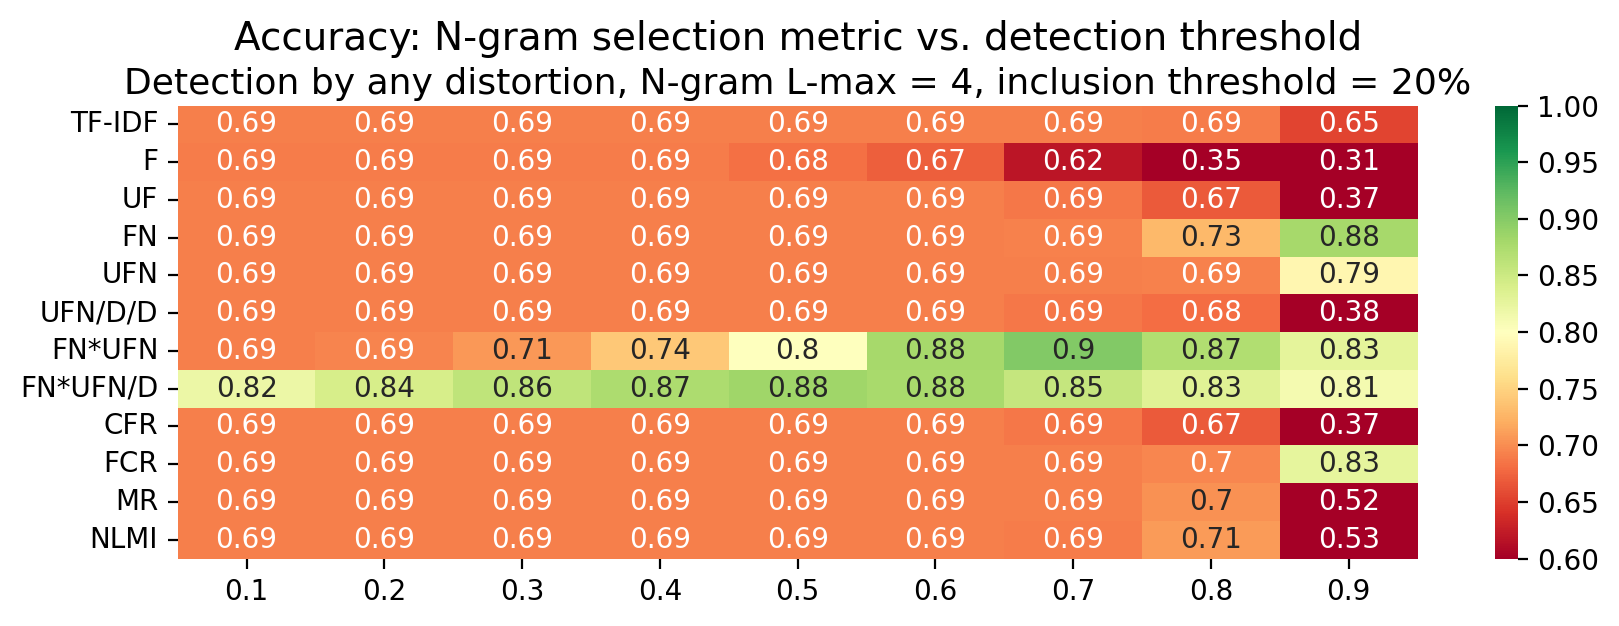

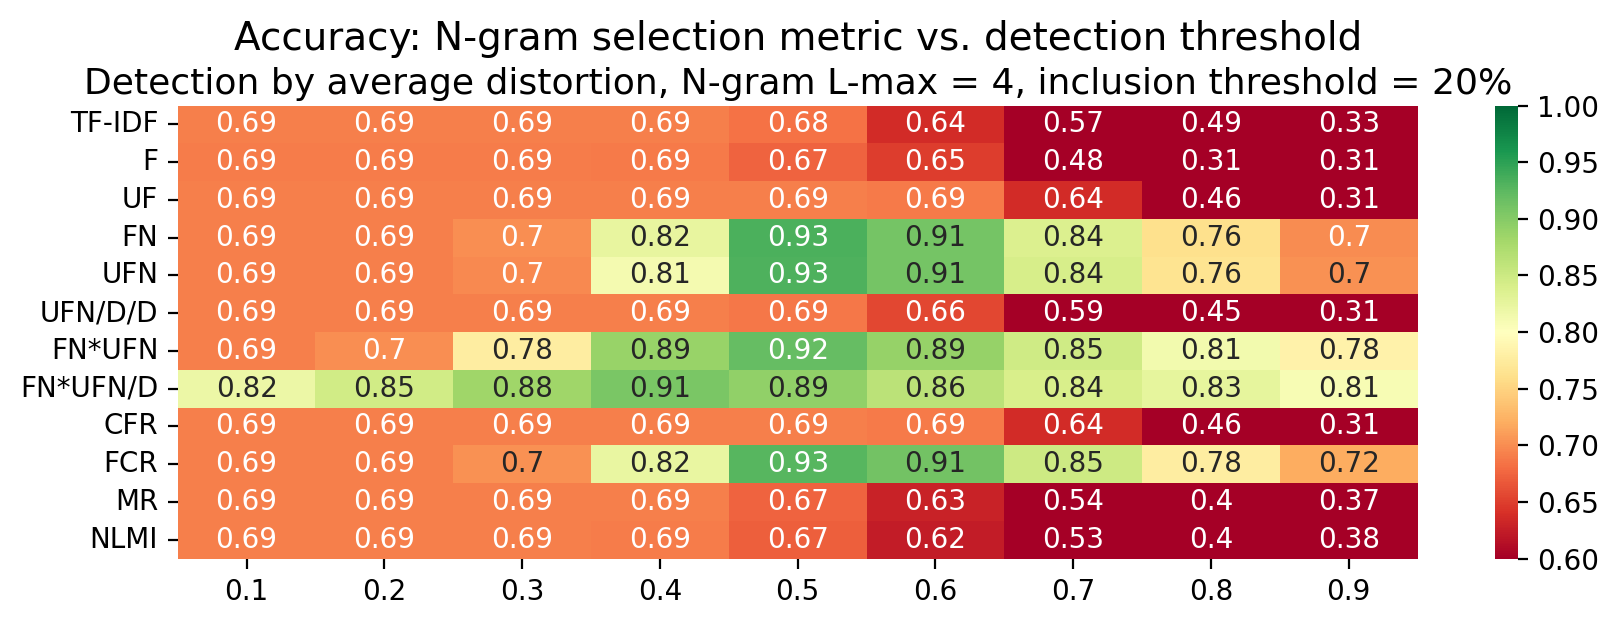

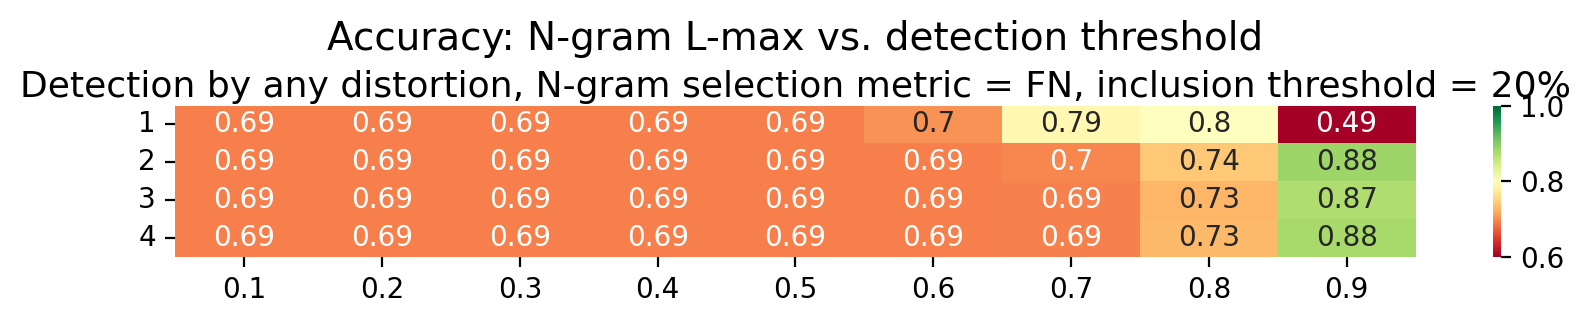

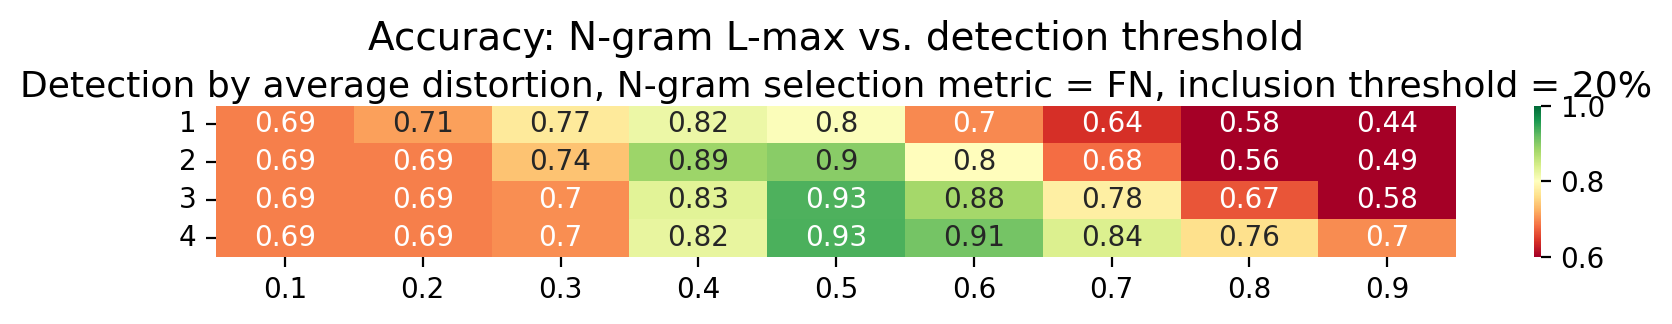

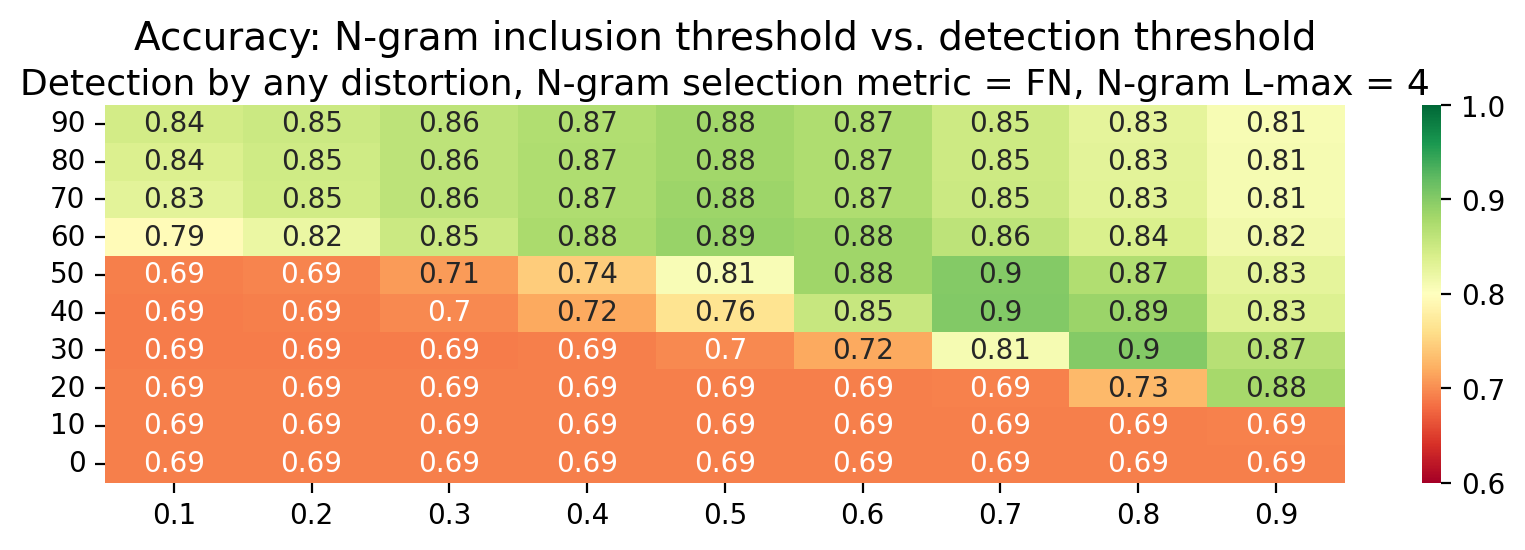

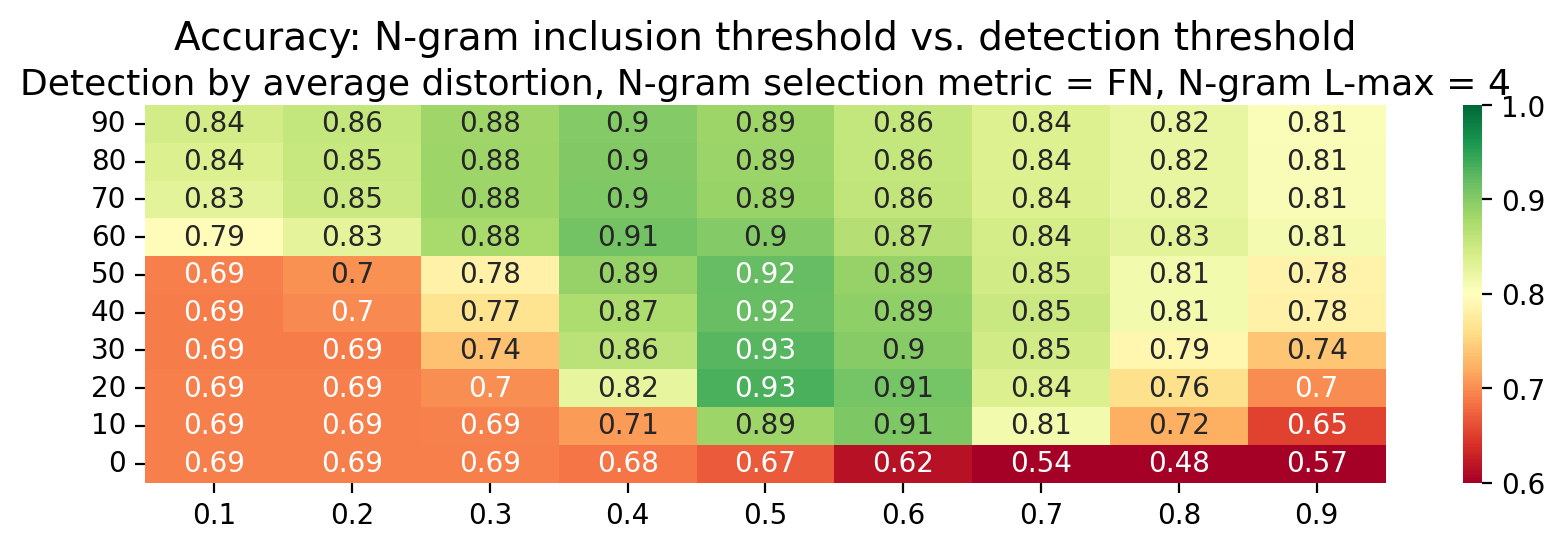

In [9]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]


# 1) N-gram selection metric - threshold
acc_analytics_threshold_any = np.zeros((len(ngram_selection_metrics), len(thresholds)))
acc_analytics_threshold_avg = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(ngram_selection_metric, 4, 20, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(ngram_selection_metric, 4, 20, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(ngram_selection_metric, 4, 20, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_analytics_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_any, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by any distortion, N-gram L-max = 4, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_avg, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by average distortion, N-gram L-max = 4, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)



# 2) ngram_max - threshold
acc_ngrammax_threshold_any = np.zeros((len(ngram_max_values), len(thresholds)))
acc_ngrammax_threshold_avg = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset('FN', ngram_max, 20, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset('FN', ngram_max, 20, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset('FN', ngram_max, 20, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngrammax_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_any, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = FN, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_avg, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = FN, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)



# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold_any = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))
acc_ngram_inclusion_threshold_avg = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset('FN', 4, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset('FN', 4, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset('FN', 4, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngram_inclusion_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_any, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = FN, N-gram L-max = 4",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_avg, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = FN, N-gram L-max = 4",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

In [10]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'3 days, 1:19:29.393803'

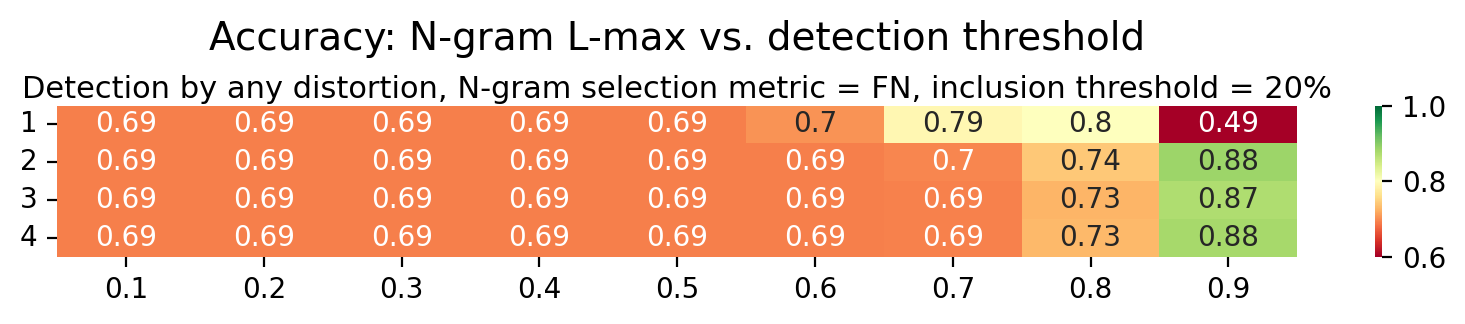

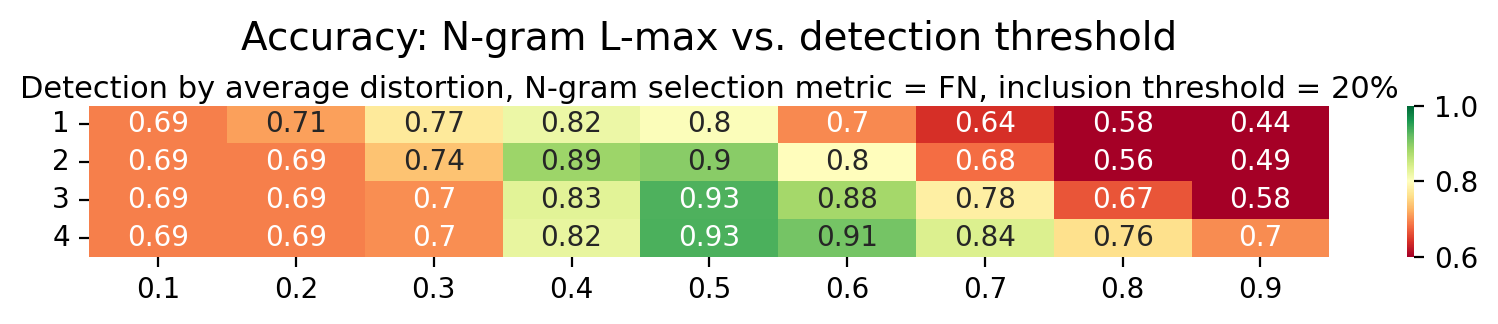

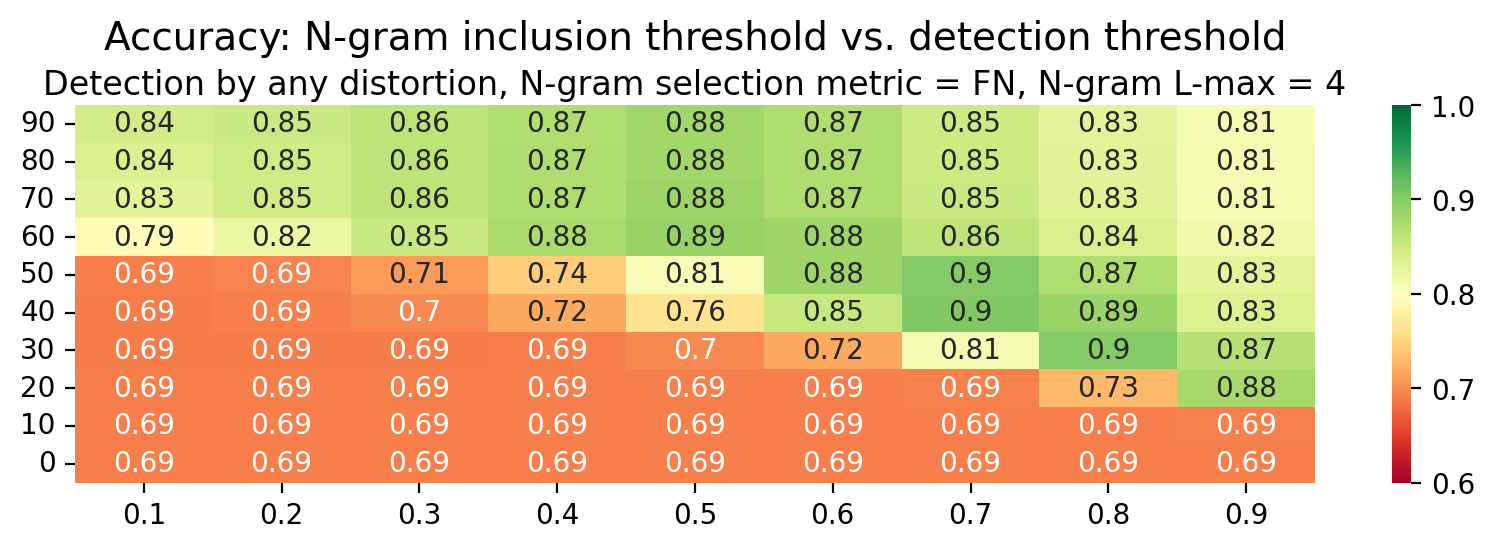

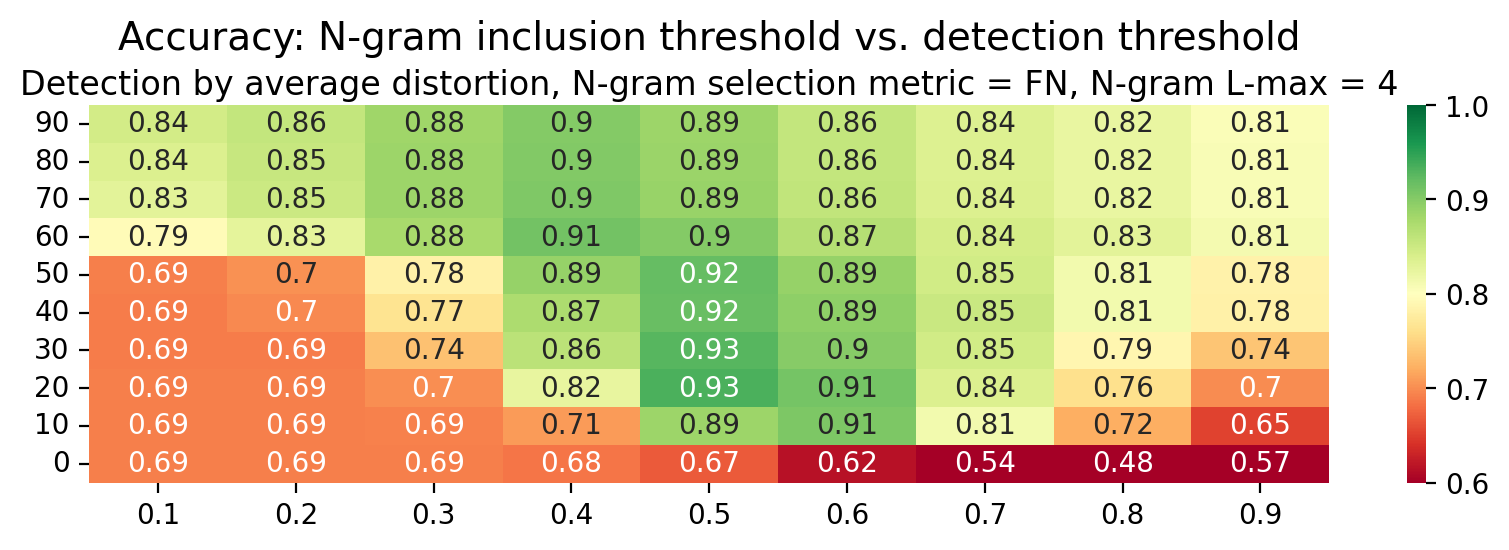

In [14]:
matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_any, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = FN, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_avg, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = FN, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_any, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = FN, N-gram L-max = 4",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_avg, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = FN, N-gram L-max = 4",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

### Our best model obtained through the optimal combination of hyper-parameters

In [15]:
# Best model
part1 = df3[df3.index % 3 == 1]
part2 = df3[df3.index % 3 == 2]
part3 = df3[df3.index % 3 == 0]

splits = [
    (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
    (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
    (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any, first_split_acc_avg = analyse_dataset('FN', 4, 20, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any, second_split_acc_avg = analyse_dataset('FN', 4, 20, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any, third_split_acc_avg = analyse_dataset('FN', 4, 20, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: FN
N-gram max length: 4
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.8230836490819002
		 0.3 0.6993561168895492 0.8230836490819002
		 0.4 0.6993561168895492 0.8230836490819002
		 0.5 0.6993561168895492 0.8230836490819002
		 0.6 0.6993561168895492 0.8230836490819002
		 0.7 0.6998514115898959 0.8231173380035027
		 0.8 0.7434373452204062 0.8440698374473209
		 0.9 0.8841010401188707 0.9187500000000001

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.6993561168895492 0.8230836490819002
		 0.2 0.6993561168895492 0.8230836490819002
		 0.3 0.7087667161961367 0.8276670574443141
		 0.4 0.8256562654779593 0.8883956880152188
		 0.5 0.9361069836552749 0.9546572934973638
		 0.6 0.9197622585438335 0.9395070948469006
		 0.7 0.846458642892521 0.8768864177918984
		 0.8 0.7711738484398217 0.8047337278106509
		 0.9 0.7102526002971769 0.739